# Content-Based Music Recommendation
## COMP9727: Recommender Systems T2 2025
*z5247852 Daniel Lawson*

## Introduction
The aim of this workbook is to develop a content-based *music recommender* similar in application to those used by Spotify, which is able to provide a "personalised playlist of songs" that matches a specified users interest. The secondary (and more important) outcome of this workbook is to provide specific examples of the issues faced when building and evaluating these sorts of systems using realistic data.

The dataset provided for this assignment is a list of 1500 songs in a tab-seperated variable (TSV) format; categorised into five topics: *dark, emotion, lifestyle, personal and sadness*. Along with the topic, 5 other fields are provided: *artist, track name, release data, genre and lyrics*. The lyrics are a subset of the song and have been cleansed of explicit content.

### Workbook Structure
The workbook is divided into five sections:
- Introduction (this section) specifying the aim of the workbook.
- Part 1: Classification where supervised learning methods are used to determine the best methods, settings and features for topic classification. An examination of the dataset and a discussion on pre-processing is also included in this section. The three models chosen are:
    - Bernoulli Naive Bayes (BNB) as defined by the Week 2 tutorial
    - Multinomial Naive Bayes (MNB) as defined by the Lecture 2 content
    - Random Forest (RF) Classification
- Part 2: Building a Recommender where the 'best' performing classifier from Part 1 is used to simulate a recommender system across several hypothetical users. Two users have been provided alongside the data, with a third defined by a real person. This section examines the performance of the recommender through several suitable metrics also defined in this section.
- Part 3: User Study where a real person is provided the recommender system as a 'beta test' with the intention of gathering useful feedback about the performance from a user point of view. Again metrics are used to examine quantative performance  alongside the qualitative feedback.
- References containing any sources used in the workbook.

#### Note on Assignment Questions
As part of the workbook, several questions are posed in the assignment specification. Answers to these questions are interleaved in the appropriate section of the pipeline. These questions are cleary marked with the **(ASSIGNMENT QUESTION X)** prefix. Note that one question may only be answered across several different sections and as such the same question number may appear multiple times in the workbook, with the part of the question noted alongside the relevant question number.

## Part 1: Topic Classification
This section of the workbook focuses on the process of classification. Three separate classifiers are built and their performance evaluated against several relevant metrics (defined later in this section). The best performing method will then be used in the actual recommender system constructed in Part 2. This section is broken up into sections by each stage of the classification pipeline as defined by the Week 2 tutorial:
1. **Loading the Data:** Where the input dataset is examined and features and data quality discussed.
2. **Initial Data Cleansing:** Where duplicates are removed and class balance is examined.
3. **Text Pre-Processing:** Where the data is cleansed to build the input features for the classifier as per Lecture 2. This section answers assignment questions *Part 1 Q2* and *Part 1 Q1.i*.
4. **Model Training and Evaluation:** Where the BNB and MNB classifier is built, appropriate metrics defined and performance evaluated. This section answers assignment questions *Part 1 Q3* and *Part 1 Q1.ii*.
5. **Variation of Number of Features:** Where the number of features (or words) is limited when using the `CountVectoriser()` and the results examined. This section answers assignment question *Part 1 Q4*.
6. **Use of an Additional Model:** Where the *Random Forest* classifier is considered for topic classification. This includes a paragraph explaining the model, as well as repeating the experiments in Section 3 to include this model. This section answers assignment question *Part 1 Q5*.
7. **Model Decision:** This section explains which combination of model N-most frequent words performed the best and will be used in Part 2 of the workbook.

### 1. Loading the Data
Before any classifier is built, the problem statement and hence the dataset must first be loaded and understood. In this workbook, the data set is provided in a TSV file `dataset.tsv` containing a list of 1500 songs. Each song is labelled as either *dark, emotion, lifestyle, personal or sadness*, with 5 other features shown in the table below:

| Feature       | Artist Name         | Track Name          | Release Date | Genre  | Lyrics                                                                    | Topic    |
|---------------|---------------------|---------------------|--------------|--------|---------------------------------------------------------------------------|----------|
| **Data Type** | String              | String              | Int64        | String | String                                                                    | String   |
| **Example**   | Panic! at the Disco | Death of a Bachelor | 2016         | Pop    | "...pile polaroids crate record shop sexy sexy look night time forget..." | Personal |

The below codeblock opens the dataset using the *Pandas* library and displays the dataset info to verify successful loading as well as see what 'type' each feature is

**Note**: The `dataset_location` variable below defines the location of the dataset. This can be changed as required.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

# Location of the assignment dataset
dataset_location = "./data/dataset.tsv"

# Load the dataset from TSV file with headers
df_initial = pd.read_csv(dataset_location, sep="\t", header=0)

# Preview the dataset to validate load
pd.set_option('display.width', 180)
pd.set_option('display.max_colwidth', 140)
print(df_initial.info())
print(df_initial.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1500 non-null   object
 1   track_name    1500 non-null   object
 2   release_date  1500 non-null   int64 
 3   genre         1500 non-null   object
 4   lyrics        1500 non-null   object
 5   topic         1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB
None
  artist_name         track_name  release_date genre  \
0      loving  the not real lake          2016  rock   
1     incubus    into the summer          2019  rock   

                                                                                                                                        lyrics      topic  
0  awake know go see time clear world mirror world mirror magic hour confuse power steal word unheard unheard certain forget bless angry we...       dark  
1  shouldn summer pre

#### General Notes About Data
To try to determine quality, thus setting expectations for the recommender, a brief examination of the data was conducted. This identified several problems, some of which will be address in pre-processing.
1. **Duplicate Data**: Several records contained duplicate data. This can easily be removed during Stage 3.
2. **Inaccurate Labelling**: Several songs have been mislabelled. For example the artist *Green Day* has three songs on the list, two correctly labelled as Rock, whilst the third (Boulevard of Broken Dreams) has been mislabelled as Pop. Whilst this does not affect the process of building the classifier (and will not be fixed in this workbook), it may cause issues for the recommender as users (i.e. rock fans) may not get recommended 'good' songs due to inaccurate data. The impact of this is discussed further in Part 3 of the assignment.
3. **Non-ASCII Characters** in the dataset, some artists have non-ASCII names, such as *ødyssee*. This may cause issues during pre-processing when deciding which characters to process and is discussed in Stage 4.
4. **Non-Standard Characters** similar to above, some of the song titles make use of non-standard characters. Examples include *06:00, [REDACTED] you and 4ever*. This is factored during the design of the pre-processor in Stage 4.

### 2. Initial Data Cleansing
The second step in the classifier pipeline (as defined by Tutorial 2) is initial data cleansing. Here the first data issue is rectified with all duplicate data removed. The below codeblock shows that *20 duplicates* were removed.

In [2]:
initial_length = df_initial.shape[0]

# Drop duplicates
df = df_initial.drop_duplicates()
dedup_length = df.shape[0]

print("Initial length:", initial_length, " Number of Duplicates removed:", initial_length - dedup_length)

Initial length: 1500  Number of Duplicates removed: 20


#### Distribution of Classes
With the duplicates removed, a plot of class distribution was built. This plot shows that the dataset is clearly **imbalanced**, with the *dark* label the most numerous, containing almost a third of total data and *emotion* only containing 5%.

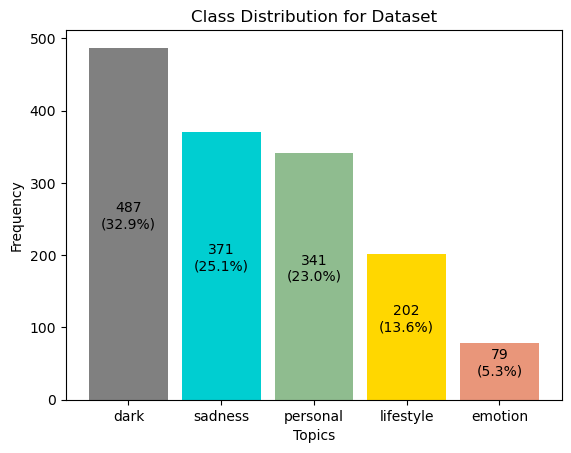

In [3]:
import matplotlib.pyplot as plt

# Plot the class distribution
topic_freq = df['topic'].value_counts()
ax = topic_freq.plot(kind='bar', width=0.85, color=['gray', 'darkturquoise', 'darkseagreen', "gold", "darksalmon"])
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title("Class Distribution for Dataset")
plt.xticks(rotation=0)

# Add label
for bar in ax.patches:
    value = bar.get_height()
    percentage = round(bar.get_height() / df.shape[0] * 100, 1)
    label_string = str(value) + "\n(" + str(percentage) + "%)"
    ax.annotate(label_string, xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2 - 10), xytext=(0, 0), textcoords='offset points', ha='center', va='bottom')
plt.show()

### 3. Text Preprocessing
#### Text Preprocessing Pipeline
**(ASSIGNMENT QUESTION 2)** *Consider all the steps in text preprocessing prior to classification to maximize overall accuracy (under the default settings of the classifiers and using CountVectorizer with standard settings). Consider the special characters to be removed (and how and when they are removed), the definition of a “word”, the stopword list (from either NLTK or scikit-learn), lowercasing and stemming/lemmatization. Summarize the preprocessing steps that you think work “best” overall and do not change this for the rest of the assignment.*

As explained in lecture 2, data must be pre-processed prior to training the model. This ensures that data is consistent ("true vs truly") as well as maximising accuracy by removing noise. The goal of both the MNB and BNB classifiers are to maximise the probability or absence of a set of words (`w`) in a class (`c`) via the following equation:
<p style="text-align: center;">$P(w_1,...,w_n|c)P(c) = P(w_1|c)...P(w_n|c)$</p>
As such, the role of pre-processing is to remove variations within words to ensure the true 'count' of a word in the document is reflective of how many times it actually appears (hence improving maximum accuracy). This is a multi-stage process, as guided by the lecture slides, with each step explained below:

1. **Convert uppercase to lowercase**: The text is first converted into lowercase, to ensure unnecessary capitalisation has been removed (hence WALK and walk will be treated as the same token). This is especially common in song titles, where songs can be capitalised for emphasis but the lowercase word appears in the song lyrics feature. A cursory glance of the data seems to indicate this has already been done (except for *REDACTED*) but has been retained in the pipeline incase any words were missed. Interestingly the term *REDACTED* has been used to replace an offensive word in the dataset, however it is expected that some users are specifically interested in songs with offensive lyrics. As such the use of *redacted* may be useful during classification (especially when related to Hip-Hop and Rock). In the below codeblock, this is the first step of the `preprocess_text` method.

2. **Remove extraneous characters:** such as *$, %, ... etc*. This is required as these characters introduce 'noise' into the document and often offer no value in analysis. Some of these extra characters do however provide value (such as being in a song title of artist) and should remain. A more detailed explanation of this comes under *aAssignment Question 1i* below. This is the second step performed in the `preprocess_text` method.

3. **Tokenise the words:** the next step performed is tokenization. This is an inbuilt method, `word_tokenize()`, in the *nltk* library which converts the cleaned sentence into a list of token words. As per the documentation (Ref A), this uses a *Punkt* sentence tokeniser algorithm (a form on unsupervised learning) which helps identify sentence boundaries.

4. **Remove Stopwords:** where words such as *the, a, we* are removed. In the `preprocess_text` method, the Stopwords list is provided by the *nltk* library. As all song titles are in English, only the English list of stopwords is used. This list also includes common words of length 1 (such as *a* and *I*), thus a separate step is not required. The removal is performed by looping through all the tokens in the token list.

5. **Apply Stemming:** stemming is defined by the NLTK documentation as removing '*morphological affixes* from words, leaving only the word stem' (Ref B). For example if the input word is *plotted*, after stemming, the output is *plot*. This makes it simpler to identify similar words by their stem and should both increase the frequency words and reduce the total number of tokens, making classification easier. In the `preprocess_text` method (and the tutorial), a *Porter Stemmer* is used, which is a well known algorithm developed by Martin Porter 1979 (Ref C).

These steps should increase the accuracy of the `CountVectoriser` by reducing the total number of tokens to only include meaningful tokens combined by their stem words, thus reducing noise. The use of the `CountVectoriser` occurs later in this workbook, however, it is noted that not all noise will be removed such as the presence of *'aaah' vs 'aaaah'* as separate tokens.

#### How to Handle Special Characters
**(ASSIGNMENT QUESTION 1i)**
*In the Jupyter notebook provided in the tutorial, the regex might remove too many special characters. Explain how you are going to fix this mistake and then highlight any changes to the code.*
In the tutorial code the method `preprocess_text` uses a regular expression (REGEX) to remove special characters with the below line.
```
text = re.sub(r'[^\w\s]', '', text)
```
This expression removes **any** character that does not match a word character (*\w*), equivalent to *a-zA-Z0-9_* or a whitespace character (*\t*) equivalent to any of *\r (carriage return), \n (newline) \t (tab), \f (form feed), \v (vertical tab)* as explained by Ref D.

After examining the data earlier in the document, we have multiple special characters such as *ø* in *ødyssee* (which does actually count as a word character), hyphens (as in the artist *ab-soul*), ampersands (*big & rich*), punctuation (*Panic! at the Disco), dollar signs (*Billy Bi$hop*) and mathematical operators (*r+r=now*). In cases such as Panic! it is probably valid to remove the character, but in cases where they form part of the name (*blink-182 or Bi\$op*) it is better to leave them. The regex is thus changed to the below line used in the `preprocess_text` method and shown in the below codeblock to limit the removal to anything except word characters, whitespace characters **OR** \$ and -. Additionally, the word *feat.* is also removed as this has no 'value', simply indicating more than one artist is in the song.
```
text = re.sub("feat.", "", text)
text = re.sub(r"[^\w\s\$-]", " ", text)
```

In [4]:
import re

# Some example words in the dataset
test_text = "ødyssee ?abc, blink-182, panic! at the disco, dan + shay, r+r=now, gabriel garzón-montano, big & rich, klischée, billy bi$hop, j.j. cale, rudeboy salute (feat. buju banton, big pun and fat joe)"

# Original REGEX
tutorial_output_text = re.sub(r"[^\w\s]", " ", test_text)
print("Input: ", test_text, " -->\n\nTutorial Regex:", tutorial_output_text, "\n")

# Remove the word feat.
fixed_output_text = re.sub("feat.", "", test_text)

# Updated REGEX
fixed_output_text = re.sub(r"[^\w\s\$]", " ", fixed_output_text)
print("Fixed Regex: ", fixed_output_text)

Input:  ødyssee ?abc, blink-182, panic! at the disco, dan + shay, r+r=now, gabriel garzón-montano, big & rich, klischée, billy bi$hop, j.j. cale, rudeboy salute (feat. buju banton, big pun and fat joe)  -->

Tutorial Regex: ødyssee  abc  blink 182  panic  at the disco  dan   shay  r r now  gabriel garzón montano  big   rich  klischée  billy bi hop  j j  cale  rudeboy salute  feat  buju banton  big pun and fat joe  

Fixed Regex:  ødyssee  abc  blink 182  panic  at the disco  dan   shay  r r now  gabriel garzón montano  big   rich  klischée  billy bi$hop  j j  cale  rudeboy salute   buju banton  big pun and fat joe 


#### Preprocess Method
The actual method used to perform preprocessing in this assignment is shown below. The 5 input features are combined into a string feature called *input* and the `preprocess_text` method is then performed against that feature. This leave the original data untouched for visualisation and preprocesses all input in a single line.

In [5]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download and view the stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print("English Stopwords are:", stop_words, "\n")

# Download the NLTK Punkt Sentence Tokenizer Algorithm and Create the Porter Stemmer
nltk.download('punkt')
ps = PorterStemmer()

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()

    # Code change from tutorial to be less restrictive in character removal
    text = re.sub("feat.", "", text)
    text = re.sub(r"[^\w\s\$]", " ", text)

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return " ".join(tokens)


# As per spec concatenate all the information into one document, then apply preprocessing
df.loc[:, 'release_string'] = df['release_date'].astype(str)
df.loc[:,'input_raw'] = df.loc[:,['artist_name', 'track_name', 'release_string', 'genre', 'lyrics']].agg(' '.join, axis=1)
df.loc[:, 'input'] = df['input_raw'].apply(preprocess_text)

# Visualise the preprocessed tokens
print(df['input'].head(2))

# Write new input to csv for manual comparison
#df.to_csv("input.csv", index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


English Stopwords are: {"mightn't", 'hers', 'all', 'not', 'between', "don't", 'over', "it's", 'you', 'above', 's', 'himself', 'him', "you'd", 'by', 'i', 'there', 'ourselves', 'are', 'here', "it'd", 'an', 'those', 'or', "wouldn't", 'ma', "couldn't", 'on', "you've", 'itself', 'nor', 'through', 'haven', 'now', 'after', 'about', 'doing', "you're", 've', 'was', 'these', "you'll", "i'm", 'most', 'if', 'few', "she'll", "won't", 'has', 'her', 'don', 'couldn', "we'll", 'shouldn', 'theirs', "she'd", "he's", 'their', 'ain', 'our', 'under', 'only', 'his', 'mightn', 'themselves', 'the', "they've", 'as', 'have', 'needn', 'she', 'any', 'been', 'below', 'being', 'he', "isn't", "they'll", 'no', 'just', "doesn't", 'because', 'mustn', 'down', "that'll", "shouldn't", 'my', 'other', "aren't", 'does', 'from', 'should', 'than', 'where', 'a', 'to', 'herself', 'yours', 'of', "should've", 'will', 'having', 'myself', 'in', "i'll", 'own', 'isn', "needn't", 'whom', 'again', 'me', "it'll", 'further', 'when', 'it', 

### 4. Model Training and Evaluation
With the pre-processing complete, the next step in the pipeline is to being the training and evaluation. This section is broken into several steps.

#### Step 1: Feature Extraction
The classifiers used in this workbook do not actually use string data as input, instead using a matrix of numerical tokens. Two common approaches for these tokens are *tf-idf* (Term Frequency - Inverse Document Frequency) values and *count tokens*. Tf-idf values are used and discussed in Part 2 of this workbook, with this section using count tokens. Count tokens, as defined in Lecture 2 are a 'statistical method' from the information retrieval domain to measures 'how important a term is within a document relative to a collection of documents'. Whilst tf-idf values are weighted to account for document length, count tokens are simply the frequency of occurrence in a document. In this dataset, the document is the concatenated inputs (the first 5 fields), whilst the collection of documents (or *corpus*) is the full dataset.

To turn the document into a set of Count Tokens, the `CountVectoriser` is used. Additionally, the tokens are stored as a dataframe to help in visualisation. The input data was found to have a total of *8868* tokens across 1480 documents. The matrix is also printed below.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert text data into Count Tokens
vectorizer = CountVectorizer()
input_tfidf = vectorizer.fit_transform(df['input'])
print("Number of Documents =", input_tfidf.shape[0], "Number of Tokens =", input_tfidf.shape[1])

# Visualise the array as a dataframe (and csv file) as per below reference
# https://www.kaggle.com/code/zeeshanlatif/countvectorizer-vs-tfidfvectorizer
visualisation_df = pd.DataFrame(input_tfidf.toarray(), columns = vectorizer.get_feature_names_out())
visualisation_df.to_csv("input_tokens.csv", index=False)
visualisation_df

Number of Documents = 1480 Number of Tokens = 8868


,00,000,10,100,14,16,182,1975,1979,1985,...,없었단다,영원하길,유리천장,잃어버리지마,잊어버리지마,친구들아,트램펄린,한번쯤은,함께라는,ﬁnish
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Step 2: Define Metrics for Analysis
**ASSIGNMENT QUESTION 3** *Compare BNB and MNB models by evaluating them with the full dataset using cross-validation. Choose appropriate metrics from those in the lecture that focus on the overall accuracy of classification (i.e. not top-N metrics). Briefly discuss the tradeoffs between the various metrics and then justify your choice of the main metrics for evaluation, taking into account whether this dataset is balanced or imbalanced. On this basis, conclude whether either of BNB or MNB is superior. Justify this conclusion with plots/tables.*

To compare the models, first it must be decided what to actually compare. As listed in the specification, *Accuracy* is the primary metric used for comparison, which is defined simply as the number of correct predictions across all classes (`c`):
<p style="text-align: center;">$Accuracy = \frac{\sum_{i}c_{ij}}{\sum_{i}\sum_{j}c_{ij}}$</p>

As this problem is a multi-class classification problem (5 classes), several other metrics also make sense. The first are the standard metrics for most machine learning problems:
- *Precision:* how many items predicted as a particular class were actually that class.
- *Recall:* how many of the actual class were actually predicted correctly.
- *F1-Score:* the harmonic mean of precision and recall.
Being a multiclass problem, with and **imbalance between classes**, as shown by the plot in the Initial Data Loading, the **macro-average** is used which measures the average of per-class measures. As per Lecture 1, macro-averages are dominated by smaller classes and hence better when dealing with imbalance. The equations for Precision, Recall and F1-Score are:
<p style="text-align: center;">$Precision(c_i) = \frac{c_{ii}}{\sum_{j}c_{ji}}$</p>
<p style="text-align: center;">$Recall(c_i) = \frac{c_{ii}}{\sum_{j}c_{ij}}$</p>
<p style="text-align: center;">$F1 = \frac{2PR}{P+R}$</p>

In Lecture 2, it was explained that there exists an inherent **trade-off** between recall and precision, explained in Lecture 1 as the Precision-Recall curve. Aiming for a higher precision reduces the number of false positives (in our case over classifying a particular class). This then causes a reduced recall (also known as sensitivity) causing more false negatives (failing to classifying other classes correctly). Thus, the algorithm is more likely to over-classify to avoid missing any positives.

The next set of useful metrics comes from the domain of Information Retrieval. As the classifier predicts which of the five labels is correct, the Jaccard index can be calculated to determine how much overlap there is between the predicted label set (P) and the truth label set (T). It is shown by the equation below where a Jaccard Score of 1 is a perfect overlap. The Jaccard score is able to handle multi-labels by calculating multiple iterations of class `i` vs non-class `i` and averaged out the results.
<p style="text-align: center;">$J(T,P) = \frac{|T\cap P|}{T\cup P}$</p>

The final metric chosen was Hamming distance. Hamming distance is similar to Jaccard score in that it compares the difference between predicted and truth labels, though instead of looking at overlap it instead calculates the fraction of wrong labels, with 0 being the target. It is given by the equation:
<p style="text-align: center;">$D(T,P) = \sum_{i=1}^{n}1(T_i \neq P_i)$</p>

Other metrics such as *Cosine similarity* and *Euclidean distance*, were considered but Cosine similarity has been saved for Part 2 of the workbook where it is used in the recommender itself. As this section focus on classification and these metrics focused on a *distance* between the results the distance from dark to personal does not have inherent meaning, thus were not selected.

##### Implementation of Metrics
The `cross_validate_model` method below is used for evaluation. Cross-validation itself is discussed later in this stage, but the method takes in a given model, the input `x` and output `y` values, the number of cross-validation folds `kf` and whether to print the classification report or just return the results in a vector. The *sklearn* `cross_valiate()` method allows for a user-defined scoring vector which in this case includes all the metrics discussed above. Note that several of these methods are custom defined by the `make_scorer` method to allow for optional parameters to be defined in the *sklearn* metrics. This is mostly restricted to how to handle divides by zero (in this case the score is 0) and to specify that *macro* averages are used. This is better defined in the *sklearn* documentation in Ref E.

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, classification_report, hamming_loss, recall_score, precision_score
import numpy as np

# Print the classification report and return accuracy_score
def accuracy_and_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred, zero_division=0))
    return accuracy_score(y_true, y_pred)

def precision_calc(y_true, y_pred):
    return precision_score(y_true, y_pred, average='macro', zero_division=0)

def recall_calc(y_true, y_pred):
    return recall_score(y_true, y_pred, average='macro', zero_division=0)

# Perform Cross-Validation on a Model with a given k-fold
def cross_validate_model(model, x, y, kf, print_classification_report=False):
    # Define the metrics
    scoring = {
        "accuracy": make_scorer(accuracy_and_classification_report, greater_is_better=True) if print_classification_report else "accuracy",
        "precision": make_scorer(precision_calc, greater_is_better=True),
        "recall": make_scorer(recall_calc, greater_is_better=True),
        "f1": "f1_macro",
        "jaccard": "jaccard_macro",
        "hamming_loss": make_scorer(hamming_loss, greater_is_better=True)
    }

    # Get the metrics
    scores = cross_validate(model, x, y, cv=kf, scoring=scoring)

    # Present Results for Visualisation:
    accuracy = round(np.mean(scores["test_accuracy"]), 4)
    jaccard = round(np.mean(scores["test_jaccard"]), 4)
    precision = round(np.mean(scores["test_precision"]), 4)
    recall = round(np.mean(scores["test_recall"]), 4)
    f1 = round(np.mean(scores["test_f1"]), 4)
    hamming = round(np.mean(scores["test_hamming_loss"]), 4)
    return [accuracy, precision, recall, f1, jaccard, hamming]

#### Step 3: Construct the Training and Test Sets
With the metrics, decided, the next step in the process is to split the data into test and training sets. As per *Assignment Q3* this is done using the **full dataset**.

**(ASSIGNMENT QUESTION 1ii)**
*In the Jupyter notebook provided in the tutorial, the evaluation is based on only one training test split rather than using cross-validation. Explain how you are going to fix this mistake and then highlight any changes to the code.*

In the tutorial code, the data was split randomly using the `train_test_split` method from the SKLearn library, with an 80:20 ratio between training and testing. As stated in the question, this means evaluation was only performed on 20% of the data, however there is no way of knowing if that 20% specifically helps or hinders evaluation. Rather than splitting once, cross-validation can be used to allow for multiple splits and hence multiple evaluations. As explained by the *skikit* documentation (Ref E), a common method of cross-validation is to split the data into *K-Folds*, with the model trained on *K-1* of the folds and tested against the remainder. Each iteration changes which fold is held back for evaluation, resulting in K iterations. Thus, evaluation is performed `K` times, allowing for more meaningful comparisons between models. Additionally, when generating the folds, it is possible to keep the class balances consistent using what is known as `StratifiedKFold` as per Ref F. This has been used in this workbook.

#### Step 4a: Model Training - Bernoulli Naive Bayes
The first model used is the Bernoulli Naive Bayes (BNB). This model aims to maximise the probability formula specified earlier:
<p style="text-align: center;">$P(w_1,...,w_n|c)P(c) = P(w_1|c)...P(w_n|c)$</p>
Where the features are the presence or **absence** of a word in the document. Thus, BNB penalises the non-occurence of a feature. As per the *skikit* documentation, it performs better with shorter datasets as penalising missing features would have less of an effect (Ref G).

The codeblock below shows the splitting into K-Folds and performing the cross-validation of the BNB model. The value of `K = 5` was chosen to balance the number of iterations with training size. This is a common option that also replicates the initial 80:20 ratio from the tutorial.

In [8]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import StratifiedKFold

# Allow KFold Cross-Validation
k = 5
stratified_cv =  StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

bnb = BernoulliNB()
bnb_metrics = cross_validate_model(bnb, input_tfidf, df['topic'], stratified_cv, print_classification_report=False)

#### Step 4b: Model Training - Multinomial Naive Bayes
The second model uses in a Multinomial Naive Bayes (MNB). Similar to BNB, it aims to maximise the equation:
<p style="text-align: center;">$P(w_1,...,w_n|c)P(c) = P(w_1|c)...P(w_n|c)$</p>
However, unlike BNB, this models features are the occurence of words in positions in the document. As such it ignores the absence of a word. The code below instantiates the model and runs the cross-valdiation algorithm.

In [9]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb_metrics = cross_validate_model(mnb, input_tfidf, df['topic'], stratified_cv, print_classification_report=False)

#### Step 5: Model Evaluation
The final stage of the Model Training and Evaluation, is the actual evaluation stage. Here the metrics discussed earlier are shown in a table to allow direct comparison, as well as the `cross_val_predict` method used to help visualise the data. The function below is as helper to show the predicted vs truth data for both models (and later a third). This is based on the provided tutorial code.

In [10]:
import matplotlib.pyplot as plt
def plot_predicted_results(y_predicted_bnb, y_predicted_mnb, y_test, class_labels, rf_model=None):
    # Plot the distribution of actual topics in the test set
    unique_true, counts_true = np.unique(y_test, return_counts=True)

    # Plot the distribution of predicted topics for both models
    unique_pred_bnb, counts_pred_bnb = np.unique(y_predicted_bnb, return_counts=True)
    unique_pred_mnb, counts_pred_mnb = np.unique(y_predicted_mnb, return_counts=True)

    # Plot settings
    plt.figure(figsize = (8,4))
    bar_width = 0.25

    # Set position of bar on the X axis
    r1 = np.arange(len(counts_true))
    r2 = [x + bar_width for x in r1]
    r3 = [x + 2*bar_width for x in r1]

    # Create subplot for 'true' distribution
    plt.bar(r1, counts_true, color='b', width=bar_width, edgecolor='white', label='Ground Truth')
    plt.bar(r2, counts_pred_bnb, color='c', width=bar_width, edgecolor='white', label='Predicted (Bernoulli Naive Bayes)')
    plt.bar(r3, counts_pred_mnb, color='g', width=bar_width, edgecolor='white', label='Predicted (Multinomial Naive Bayes)')

    # Don't always plot the third model
    if rf_model is not None:
        unique_pred_rf, counts_pred_rf = np.unique(rf_model, return_counts=True)
        r4 = [x + 3*bar_width for x in r1]
        plt.bar(r4, counts_pred_rf, color='y', width=bar_width, edgecolor='white', label='Predicted (Random Forest)')

    plt.xlabel('Topic', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')
    plt.title("Frequency Distribution of True and Predicted Topics", fontweight='bold')

    plt.xticks([r + bar_width for r in range(len(counts_true))], class_labels, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.savefig('topic_distribution.png')
    plt.show()

From the plot of the predicted vs truth labels for both models below, it can be seen that Multinomial Naive Bayes performed far better than Bernoulli Naive Bayes. BNB was prone to over-predicting the occurrence of *dark* and *personal*, whilst ignoring the rest. It is noted that these two were the largest of the 5 sets, indicating there were insufficient samples to identify the other 3.

Secondly, from the table (also generated by the below code block), it can be seen that the Multinomial Naive Bayes provides the best results across all metrics except for Hamming Distance, especially in Accuracy, Recall and F1-Score. This isn't surprising as all 8868 features were used in the model and BNB penalises missing features, whilst MNB does not. Based on the table alone, it can be concluded that MNB is superior in this case, though the final decision of the model for Part 2 occurs later in this workbook.

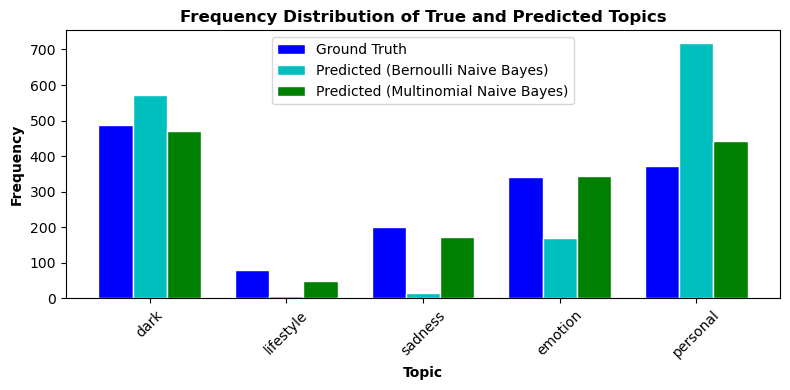

Model,Accuracy,Precision,Recall,F1-Score,Jaccard Similarity,Hamming Distance
Bernoulli Naive Bayes,0.5243,0.3831,0.3793,0.3393,0.2383,0.4757
Multinomial Naive Bayes,0.7953,0.7535,0.7148,0.726,0.5945,0.2047


In [11]:
# Print the metrics in human-readable table
from sklearn.model_selection import cross_val_predict
import tabulate

# Get the class labels from the dataset
topic_identifiers = df['topic'].unique().tolist()

y_bnb = cross_val_predict(bnb, input_tfidf, df['topic'], cv=stratified_cv)
y_mnb = cross_val_predict(mnb, input_tfidf, df['topic'], cv=stratified_cv)

plot_predicted_results(y_bnb, y_mnb, df['topic'], topic_identifiers)

# Display as HTML Table
data = [["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Jaccard Similarity", "Hamming Distance"],
        ["Bernoulli Naive Bayes", bnb_metrics[0], bnb_metrics[1], bnb_metrics[2], bnb_metrics[3], bnb_metrics[4], bnb_metrics[5]],
        ["Multinomial Naive Bayes", mnb_metrics[0], mnb_metrics[1], mnb_metrics[2], mnb_metrics[3], mnb_metrics[4], mnb_metrics[5]],]
table = tabulate.tabulate(data, tablefmt="html")
table

Finally, to further support the indication that MNB was the superior model, the classification report and confusion matrix for the `cross_val_predict` is shown. Again it can be seen that BNB would over-classify *dark* and *personal*, resulting in high recall for those specific classes but low precision; it was also unable to correctly identify a single instance of emotion in this set, though MNB also struggled in that regard. Conversely, the more spread MNB model had both higher precision and recall across all classes.

Classification Report for BNB
              precision    recall  f1-score   support

        dark       0.62      0.73      0.67       487
     emotion       0.00      0.00      0.00        79
   lifestyle       0.20      0.01      0.03       202
    personal       0.65      0.33      0.43       341
     sadness       0.43      0.82      0.56       371

    accuracy                           0.52      1480
   macro avg       0.38      0.38      0.34      1480
weighted avg       0.49      0.52      0.47      1480


 Classification Report for MNB
              precision    recall  f1-score   support

        dark       0.83      0.80      0.82       487
     emotion       0.52      0.33      0.40        79
   lifestyle       0.84      0.72      0.77       202
    personal       0.83      0.84      0.84       341
     sadness       0.74      0.89      0.81       371

    accuracy                           0.80      1480
   macro avg       0.75      0.72      0.73      1480
weighted avg   

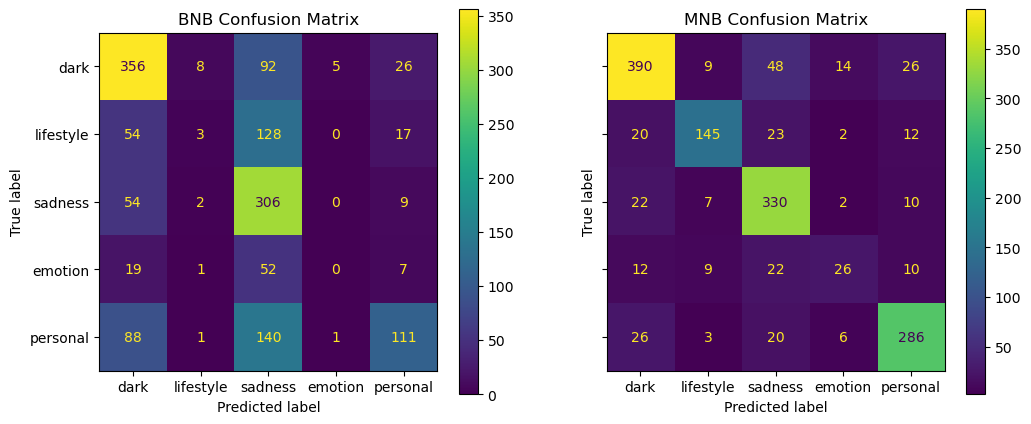

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot Confusion Matrix side by side
cm_bnb = confusion_matrix(df['topic'], y_bnb, labels=topic_identifiers)
disp_bnb = ConfusionMatrixDisplay(cm_bnb, display_labels=topic_identifiers)

cm_mnb = confusion_matrix(df['topic'], y_mnb, labels=topic_identifiers)
disp_mnb = ConfusionMatrixDisplay(cm_mnb, display_labels=topic_identifiers)

print("Classification Report for BNB")
print(classification_report(df['topic'], y_bnb))

print("\n Classification Report for MNB")
print(classification_report(df['topic'], y_mnb))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey="row")
axs[0].set_title("BNB Confusion Matrix")
disp_bnb.plot(ax=axs[0])
axs[1].set_title("MNB Confusion Matrix")
disp_mnb.plot(ax=axs[1])

### 5. Variation of Number of Features
**ASSIGNMENT QUESTION 4.** *Consider varying the number of features (words) used by BNB and MNB in the classification, using the sklearn setting which limits the number to the top N most frequent words in the Vectorizer. Compare classification results for various values for N and justify, based on experimental results, one value for N that works well overall and use this value for the rest of the assignment.*

As stated in the last section, BNB penalises the absence of a word in a document, hence performing poorly in large vocabularies. In the pre-processing stage, it was identified that the `CountTokeniser` produced 8868 tokens, most of which potentially has few occurrences in a document. Thus reducing the number of tokens should reduce the amount of *noise* in the classifiers. The code below, repeats the tokenization phase from earlier this time using the `max_features` flag to limit to N features. The two models are then re-trained with cross_validation and the same metrics produced. Results are then produced in a table for easy comparison.


In [13]:
def train_with_word_limit(n_features):
    # Re-Vectorise with top-N features only
    limit_vectorizer = CountVectorizer(max_features=n_features)
    limit_count_tokens = limit_vectorizer.fit_transform(df['input'])

    # Repeated Stratified K Folds and Training for both models
    limit_stratified_cv =  StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    limit_bnb = BernoulliNB()
    limit_bnb_metrics = cross_validate_model(limit_bnb, limit_count_tokens, df['topic'], limit_stratified_cv)

    limit_mnb = MultinomialNB()
    limit_mnb_metrics = cross_validate_model(limit_mnb, limit_count_tokens, df['topic'], limit_stratified_cv)

    return [["BNB", n_features, limit_bnb_metrics[0], limit_bnb_metrics[1], limit_bnb_metrics[2], limit_bnb_metrics[3], limit_bnb_metrics[4], limit_bnb_metrics[5]],
            ["MNB", n_features, limit_mnb_metrics[0], limit_mnb_metrics[1], limit_mnb_metrics[2], limit_mnb_metrics[3], limit_mnb_metrics[4], limit_mnb_metrics[5]], ]

# Headings for tables
data = [["Model", "N", "Accuracy", "Precision", "Recall", "F1-Score", "Jaccard Similarity", "Hamming Distance"]]

# Repeat the Cross-Validation for different values for N
n_values = [10, 20, 50, 100, 200, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 1000, 1500, 2000]
bnb_accuracy = []
mnb_accuracy = []
for n in n_values:
    results = train_with_word_limit(n)
    data.append(results[0])
    data.append(results[1])

    bnb_accuracy.append(results[0][2])
    mnb_accuracy.append(results[1][2])

# Show Results
table = tabulate.tabulate(data, tablefmt="html")
table

Model,N,Accuracy,Precision,Recall,F1-Score,Jaccard Similarity,Hamming Distance
BNB,10,0.4473,0.286,0.3241,0.297,0.1975,0.5527
MNB,10,0.4899,0.4519,0.4249,0.4308,0.284,0.5101
BNB,20,0.4845,0.4417,0.377,0.3748,0.2491,0.5155
MNB,20,0.5432,0.5103,0.5177,0.5108,0.3529,0.4568
BNB,50,0.5399,0.4712,0.4381,0.4421,0.3023,0.4601
MNB,50,0.6676,0.6282,0.6534,0.6363,0.475,0.3324
BNB,100,0.5845,0.5303,0.5016,0.5098,0.3562,0.4155
MNB,100,0.7588,0.7379,0.7395,0.7365,0.5885,0.2412
BNB,200,0.598,0.5378,0.5181,0.5228,0.3693,0.402
MNB,200,0.8338,0.827,0.8107,0.8155,0.6931,0.1662


The accuracy metric from each experiment is then plotted, to identify the approximate best value. It can be seen that both models initially perform very poorly as the vocabulary is extremely limited, making classification impossible. The models then both improve up to a limit before providing too many tokens to accurately differentiate classes. Whilst MNB performed better over the entire N compared to BNB, both models appeared to have their best results around a value of $N \approx 350$. Thus, the best value and combination for Part 2 would be **MNB for a value of N=350**. Note this doesn't take into account the results of the third model, so is not yet the final decision.

BNB Maximum Accuracy is 0.652 for 350
MNB Maximum Accuracy is 0.8736 for 350


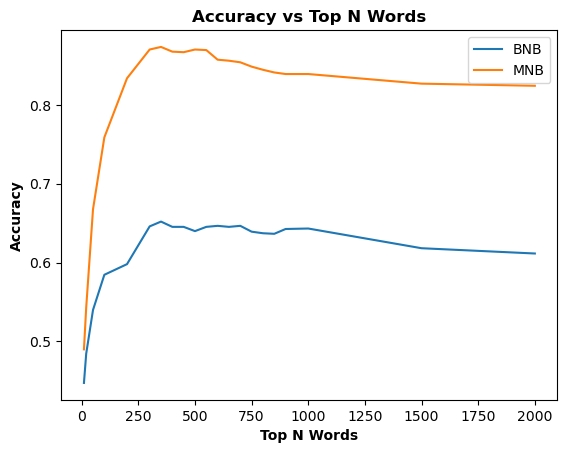

In [14]:
def best_result(accuracy_array, n_values_array):
    best_index = np.argmax(accuracy_array)
    return "Maximum Accuracy is " + str(accuracy_array[best_index]) + " for " + str(n_values_array[best_index])

print("BNB " + best_result(bnb_accuracy, n_values))
print("MNB " + best_result(mnb_accuracy, n_values))

# Plot the Accuracy vs N
plt.plot(n_values, bnb_accuracy, label="BNB")
plt.plot(n_values, mnb_accuracy, label="MNB")

# Add Legend and Labels
plt.legend()
plt.xlabel('Top N Words', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title("Accuracy vs Top N Words", fontweight='bold')

plt.show()

### 6. Use of an Additional Model: Random Forest
**ASSIGNMENT QUESTION 5** *Choose one other machine learning method, summarize this method in a single tutorial-style paragraph and explain why it is suitable for topic classification for this dataset. Use the implementation of this method from a standard machine learning library such as sklearn to implement this method on the music dataset using the same text preprocessing as for BNB and MNB. If the method has any hyperparameters for tuning, explain the selection of those settings (or use the default settings), and present a concrete hypothesis for how this method will compare to BNB and MNB. Conduct experiments (and show the code for these experiments) using cross-validation and comment on whether you confirmed (or not) your hypothesis. Finally, compare this method to BNB and MNB on the metrics you used in Step 3 and choose one overall “best” method and settings for topic classification.*

One potentially promising model for classification, as both mentioned in lectures and popular online (Ref H) is the use of Random Forests (RF). Random Forests are a collection of decision trees, each formed on a different combination of decisions (Ref I). As decision trees are built by asking a series of A or B questions, there can be much variation between two individual trees. The expectation is that by using a 'forest' of these trees, they can form an ensemble style method for classification which classifies based on which class received the most votes across all trees. The use of many trees also helps reduce over-fitting as they need a consensus of different trees to classify. In the case of the music dataset, it should be particularly good at handling missing features (Count Tokens) as they just won't be part of that tree Thus the expectation (or hypothesis) is that it should perform well compared to the Bayesian classifiers explored earlier.

The code below, shows the instantiation of the Random Forest. First the pre-processing is performed again on the **full dataset**, with the full 8869 tokens printed for confirmation. Again a Stratified K-Fold is used to allow for Cross-Validation. Random Forests have several hyperparameters, most of which are beyond the scope of this assignment. However two that are considered fpr tuning are `max_depth` and `n_estimators`. Deeper trees can lead to overfitting and longer training time, whilst the number of estimators is the number of trees, again increasing training time but potentially leading to higher accuracy. The code block below varies both these parameters over a range of common values (the default parameters are `n_estimators=100` and `max_depth=None`.

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Re-tokenise with full dataset
vectorizer = CountVectorizer()
input_tfidf = vectorizer.fit_transform(df['input'])
print("Number of Documents =", input_tfidf.shape[0], "Number of Tokens =", input_tfidf.shape[1])

stratified_cv =  StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Hyperparameters
max_depths = [10, 20, 30, 40, 50, None]
n_estimators = [50, 100, 150, 200, 250]
results = [["Max Depth", "Num Estimators", "Accuracy", "Precision", "Recall", "F1-Score", "Jaccard Similarity", "Hamming Distance"]]

# Test parameters
for max_depth in max_depths:
    for n_estimator in n_estimators:
        rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator)
        rf_metrics = cross_validate_model(rf, input_tfidf, df['topic'], stratified_cv)

        results.append([max_depth, n_estimator, rf_metrics[0], rf_metrics[1], rf_metrics[2], rf_metrics[3], rf_metrics[4], rf_metrics[5]])

# Plot Results
table = tabulate.tabulate(results, tablefmt="html")
table

Number of Documents = 1480 Number of Tokens = 8868


Max Depth,Num Estimators,Accuracy,Precision,Recall,F1-Score,Jaccard Similarity,Hamming Distance
10,50,0.5,0.5114,0.3439,0.3168,0.2159,0.5
10,100,0.5176,0.4097,0.3569,0.3306,0.2303,0.4824
10,150,0.5115,0.4153,0.3515,0.3245,0.2253,0.4885
10,200,0.5236,0.4683,0.3618,0.3381,0.2367,0.4764
10,250,0.5128,0.464,0.3527,0.3283,0.2272,0.4872
20,50,0.6027,0.5723,0.4416,0.4263,0.3112,0.3973
20,100,0.6176,0.5826,0.4491,0.4296,0.3192,0.3824
20,150,0.6236,0.614,0.4553,0.4381,0.3269,0.3764
20,200,0.6203,0.6582,0.4525,0.4381,0.3251,0.3797
20,250,0.625,0.6156,0.4559,0.4392,0.3282,0.375


From the above table, the best version of the hyperparameters was to have `max_depth=None` and `n_estimators=200`. The codeblock below, shows the table of metrics for each of the three models with no limit on features and the plot of truth vs predicted on each of the three models using the `cross_val_predict` method.

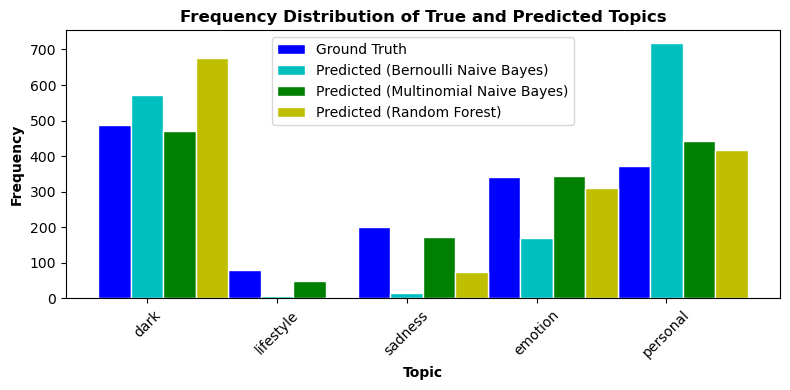

Model,Accuracy,Precision,Recall,F1-Score,Jaccard Similarity,Hamming Distance
Bernoulli Naive Bayes,0.5243,0.3831,0.3793,0.3393,0.2383,0.4757
Multinomial Naive Bayes,0.7953,0.7535,0.7148,0.726,0.5945,0.2047
Random Forest,0.702,0.6443,0.5497,0.5509,0.4256,0.298


In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

# Train the model on all the training data and plot against test
identifiers = df['topic'].unique().tolist()

# Re-define models (as standalone)
rf = RandomForestClassifier(n_estimators=200, max_depth=None)
bnb = BernoulliNB()
mnb = MultinomialNB()

# Retrain with cross-validation for metrics
bnb_metrics = cross_validate_model(bnb, input_tfidf, df['topic'], stratified_cv)
mnb_metrics = cross_validate_model(mnb, input_tfidf, df['topic'], stratified_cv)
rf_metrics = cross_validate_model(rf, input_tfidf, df['topic'], stratified_cv)

# Then predict for plot
y_pred_bnb = cross_val_predict(bnb, input_tfidf, df['topic'], cv=stratified_cv)
y_pred_mnb = cross_val_predict(mnb, input_tfidf, df['topic'], cv=stratified_cv)
y_pred_rf = cross_val_predict(rf, input_tfidf, df['topic'], cv=stratified_cv)

plot_predicted_results(y_pred_bnb, y_pred_mnb, df['topic'], identifiers, rf_model=y_pred_rf)

# Show metrics in table form
data = [["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Jaccard Similarity", "Hamming Distance"],
        ["Bernoulli Naive Bayes", bnb_metrics[0], bnb_metrics[1], bnb_metrics[2], bnb_metrics[3], bnb_metrics[4], bnb_metrics[5]],
        ["Multinomial Naive Bayes", mnb_metrics[0], mnb_metrics[1], mnb_metrics[2], mnb_metrics[3], mnb_metrics[4], mnb_metrics[5]],
        ["Random Forest", rf_metrics[0], rf_metrics[1], rf_metrics[2], rf_metrics[3], rf_metrics[4], rf_metrics[5]]]
table = tabulate.tabulate(data, tablefmt="html")
table


Finally, the classification report for Random Forest and confusion matrix of all three models are shown, where it can be seen that, whilst the Random Forest Model performed better than the BNB model, the MNB model still had the higher overall scores across all metrics. From the confusion matrix and above plot, Random Forest was found to have the same issue as BNB, where it over-classified Dark and Personal (though inversely to BNB), and was unable to identify Lifestyle. Thus, the initial hypothesis for Random Forests was disproven.


 Classification Report for Random Forest
              precision    recall  f1-score   support

        dark       0.64      0.89      0.74       487
     emotion       1.00      0.03      0.05        79
   lifestyle       0.85      0.31      0.45       202
    personal       0.76      0.70      0.73       341
     sadness       0.70      0.79      0.74       371

    accuracy                           0.69      1480
   macro avg       0.79      0.54      0.54      1480
weighted avg       0.73      0.69      0.66      1480



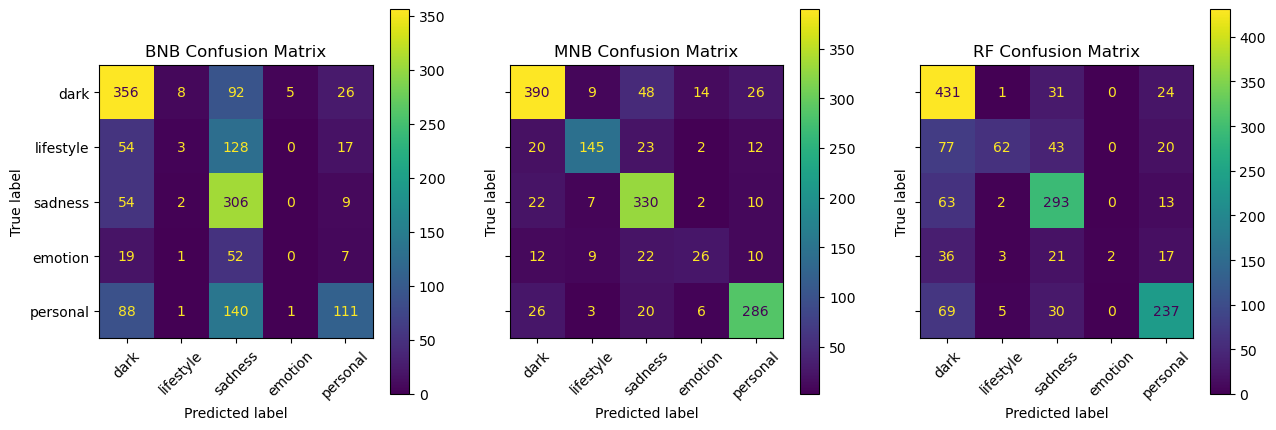

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot Confusion Matrix side by side
cm_bnb = confusion_matrix(df['topic'], y_bnb, labels=topic_identifiers)
disp_bnb = ConfusionMatrixDisplay(cm_bnb, display_labels=topic_identifiers)

cm_mnb = confusion_matrix(df['topic'], y_mnb, labels=topic_identifiers)
disp_mnb = ConfusionMatrixDisplay(cm_mnb, display_labels=topic_identifiers)

cm_rf = confusion_matrix(df['topic'], y_pred_rf, labels=topic_identifiers)
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=topic_identifiers)

print("\n Classification Report for Random Forest")
print(classification_report(df['topic'], y_pred_rf))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey="row")
axs[0].set_title("BNB Confusion Matrix")
disp_bnb.plot(ax=axs[0], xticks_rotation=45)
axs[1].set_title("MNB Confusion Matrix")
disp_mnb.plot(ax=axs[1], xticks_rotation=45)
axs[2].set_title("RF Confusion Matrix")
disp_rf.plot(ax=axs[2], xticks_rotation=45)

### 7. Decision on Best Model
After performing several experiments on Multinomial Naive Bayes, Bernoulli Naive Bayes and Random Forests classifiers, as well as examining the impact that restricting the number of features used in training the model; the following could be concluded:
- **Best Performing Model**: Multinomial Naive Bayes with default parameters
- **Maximum Number of Features in Tokenization**: 350

## Part 2: Recommendation Methods
The second part of this workbook uses the best topic classifier from Part 1 to simulate a recommender system against a variety of potential users. These users are a combination of:
- Provided Users (User 1, User 2)
- Created User (User 3)
- Real World User (not used until Part 3).

For each of these users, a user profile is generated and techniques for matching songs to those profiles conducted. Each of these matches are measured using several metrics (as defined later in this section) and conclusions made. This section is broken up into sections by each stage of the recommendation pipeline:
1. **Generating the Dataset:** Where the dataset from Part 1 is again loaded and parsed into the form required for Part 2. This section answers part of assignment question *Part 2 Q1*.
2. **Building the User Profiles:** Where the profiles of the three users above are created using a combination of the training set and the provided keywords. This section answers part of assignment question *Part 2 Q1*.
3. **Generating Recommendations:** Where each user is provided a list of N-Recommendations. This section includes the design decision of the value of N. This section answers part of assignment question *Part 2 Q2*
4. **Experimentation of M-Keywords:** Where the effect that the number of keywords used in the profile has on recommendations is examined. This section answers part of assignment question *Part 2 Q2*.
5. **Model Decision:** This section explains which algorithm is used for matching user profiles to songs including the decision of M-Keywords. The choice here will then be used in Part 3 of the Workbook.

### 1. Generating the Dataset
As explained in the specification the dataset from Part 1 is again used for the recommendation, though this time the dataset is split into explicit training and test datasets. It is assumed that the data is arranged in time order over several weeks, with each week corresponding to 250 songs. This means unlike Part 1 there are no 'duplicate records'. as songs can be re-heard in multiple weeks. The dataset is defined by the following split:
- **Training Data**: Weeks 1-3 or songs 1-750
- **Test Data**: Week 4 or songs 751-1000

The pre-processing is *similar* to Part 1, in that the features are still concatenated to make a single document for each song. However rather than using a `CountVectorisier`, a `TF-IDFVectoriser` is instead used. This still generates tokens however rather than a simple count of frequency, it now weights each token by the total number of tokens in the document (term frequency) and also by 'how much information it provides' based on its appearance across all documents (inverse document frequency). Thus frequent terms that appear in all documents can be seen to hold less information. The equation for tf-idf is shown below (as defined in Ref J), where `t` denotes the term, `d` denotes the document and `D` denotes the corpus. Finally, `f` is the raw count of a term in the document. Note other variants of these equations also exist.
<p style="text-align: center;">$tf(t,d) = \frac{f_{t,d}}{\sum_{t' \in d}f_{t',d}}$</p>
<p style="text-align: center;">$idf(t,D) = log{\frac{|1 + D|}{df(w) + 1}}$</p>
<p style="text-align: center;">$tfidf(t,d,D) = tf(t,d) \times idf(t,D)$</p>

The codeblock below, re-loads the dataset, re-processes as per Part 1 and splits the dataset into training and test data. Next using a `TfidfVectorizer` with *Max_Features=350* as per Part 1, the code block also tokenises the training set using the `fit_transform()` method to generate the tf-idf vectors. It also does the same with the test data (though only using `transform` to keep the original tokens). Finally, the best performing model from Part 1 - the Multinomial Bayes model, is trained against the training data.

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Best performing model and parameters from Part 1
mnb = MultinomialNB()
max_features = 350

# Location of the assignment dataset
dataset_location = "./data/dataset.tsv"

# Load the dataset from TSV file with headers
df = pd.read_csv(dataset_location, sep="\t", header=0)

# Pre-process as per part 1:
df.loc[:, 'release_string'] = df['release_date'].astype(str)
df.loc[:,'input_raw'] = df[['artist_name', 'track_name', 'release_string', 'genre', 'lyrics']].agg(' '.join, axis=1)
df.loc[:, 'input'] = df['input_raw'].apply(preprocess_text)

# Split into test and training data:
df_train = df.iloc[:750]
df_test = df.iloc[750:1000]

# Verify by Printing Shape
print("Training Data shape:", df_train.shape, "Test Data Shape:", df_test.shape)

# Write new input to csv for manual comparison
#df_train.to_csv("train.csv", index=False)
#df_test.to_csv("test.csv", index=False)

# Convert the training and test data into TFIDF Vectors
vectorizer = TfidfVectorizer(max_features=max_features)
train_tfidf_full = vectorizer.fit_transform(df_train['input'])
test_tfidf_full = vectorizer.transform(df_test['input'])

# Train the model on the training data
mnb.fit(train_tfidf_full, df_train['topic'])

Training Data shape: (750, 9) Test Data Shape: (250, 9)


MultinomialNB()

#### Building the Truth Data
The next stage of preparing for the recommender system is to prepare the *truth* data. As both datasets already contain the true topic classification, we can split both datasets by the 5 topics. As per the specification, when developing the user profile using the data from Weeks 1-3, we *assume the true topic is not known but instead the topic classifier is used to predict the song topic and shown to the user under that topic*. As such whilst the recommender itself will not use the truth data, it is required for the calculation of metrics when assesses the recommenders performance. The code below splits both datasets into topic via a dictionary and also transforms them into tfidf vectors for each topic.

In [19]:
def build_truth_data(truth_df):
    # Get the total number of topics (as keys to dictionary)
    topics = truth_df['topic'].unique().tolist()

    # Create a dictionary to split each row into separate dataframes by topic:
    truth_dataframe_dict = {elem : pd.DataFrame() for elem in topics}
    for key in truth_dataframe_dict.keys():
        truth_dataframe_dict[key] = truth_df[:][truth_df.topic == key]

    # Then build tfidf matrices for each topic
    tfidf_topic_vectorizer = {elem : [] for elem in topics}
    num_songs = 0
    for key in tfidf_topic_vectorizer.keys():
        topic_df = truth_dataframe_dict[key]
        topic_tfidf = vectorizer.transform(topic_df['input'])
        print("For Topic " + key + " Number of Documents =", topic_tfidf.shape[0], "Number of Tokens =", topic_tfidf.shape[1])

        # Then add to tokenised_dict
        tfidf_topic_vectorizer[key] = topic_tfidf
        num_songs += topic_tfidf.shape[0]

    print("Total Number of tracks in Test data: ", num_songs)
    return truth_dataframe_dict, tfidf_topic_vectorizer

print("For truth training data:")
train_truth_dict, train_truth_tfidf = build_truth_data(df_train)

print("\nFor truth test data:")
test_truth_dict, test_truth_tfidf = build_truth_data(df_test)

For truth training data:
For Topic dark Number of Documents = 246 Number of Tokens = 350
For Topic lifestyle Number of Documents = 92 Number of Tokens = 350
For Topic sadness Number of Documents = 182 Number of Tokens = 350
For Topic emotion Number of Documents = 42 Number of Tokens = 350
For Topic personal Number of Documents = 188 Number of Tokens = 350
Total Number of tracks in Test data:  750

For truth test data:
For Topic sadness Number of Documents = 69 Number of Tokens = 350
For Topic personal Number of Documents = 51 Number of Tokens = 350
For Topic dark Number of Documents = 81 Number of Tokens = 350
For Topic lifestyle Number of Documents = 32 Number of Tokens = 350
For Topic emotion Number of Documents = 17 Number of Tokens = 350
Total Number of tracks in Test data:  250


#### Building the Real Train and Test Data
**ASSIGNMENT QUESTION 1** *Use information retrieval algorithms to “match” user profiles to “documents”. The classifier from Part 1 assigns a new song to one of the 5 topics, and this song will be recommended to the user if the tf-idf vector for the song is similar to the tf-idf vector for the profile of the user in the predicted topic. The user profile for each topic consists of the words, (or top M words), representing the interests of the user in that topic, computed as a tf-idf vector across all songs predicted in that topic of interest to the user. Use these tf-idf values to define a user profile, which consists of a vector for each of the 5 topics. For each topic, combine the songs from the training set predicted to be in that topic that the user “likes” into one (larger) document, and use the vectorizer to define a tf-idf vector for each such document (topic).*

As stated above, the recommender does NOT know the real topic of any song in the test set, instead using the predicted topic. As such, the train and test data are again split by the 5 topics, this time using the predicted topic from the Multinomial Naive Bayes classifier. After splitting into the 5 topics, 5 tfidif matrices are generated. This is shown in the code block below:

In [20]:
# Bucket songs by classifier for both test and training data
def bucket_songs(bucket_df, tfidf_list, print_results=True):
    # Get the total number of topics (as keys to dictionary)
    topics = bucket_df['topic'].unique().tolist()

    # Also store the predicted result for metrics
    classification_results = []

    # Create a dictionary to split each row into separate dataframes by predicted topic:
    predicted_dict = {elem : [] for elem in topics}
    predicted_dataframe_dict = {elem : pd.DataFrame() for elem in topics}
    for tfidf_idx, tfidf_value in enumerate(tfidf_list):
        original_song = bucket_df.iloc[tfidf_idx, :]  # Get song from original dataframe

        # Predict and assign
        predicted_topic = mnb.predict(tfidf_value)[0]

        predicted_dict[predicted_topic].append(original_song)
        classification_results.append(predicted_topic)
        
    # Then build tfidf matrices for each topic
    tfidf_dict = {elem : [] for elem in topics}
    num_songs = 0
    for key, topic_list in predicted_dict.items():
        if len(topic_list) > 0:
            topic_df = pd.DataFrame(topic_list)
            topic_tfidf = vectorizer.transform(topic_df['input'])

            # then add to dictionary
            tfidf_dict[key] = topic_tfidf

            if print_results:
                print("For Topic " + key + " Number of Documents =", topic_tfidf.shape[0], "Number of Tokens =", topic_tfidf.shape[1])
            num_songs += topic_tfidf.shape[0]

    # Then convert each list back to a dataframe (for ease of processing later)
    for key, topic_list in predicted_dict.items():
        predicted_dataframe_dict[key] = pd.DataFrame(topic_list)

    if print_results:
        print("Total Number of tracks in Test data: ", num_songs)
    return predicted_dataframe_dict, tfidf_dict, classification_results

print("For real training data:")
train_dict, train_tfidf_dict, train_classifications = bucket_songs(df_train, train_tfidf_full)

print("\nFor real test data:")
test_dict, test_tfidf_dict, test_classifications = bucket_songs(df_test, test_tfidf_full)

For real training data:
For Topic dark Number of Documents = 286 Number of Tokens = 350
For Topic lifestyle Number of Documents = 61 Number of Tokens = 350
For Topic sadness Number of Documents = 195 Number of Tokens = 350
For Topic emotion Number of Documents = 1 Number of Tokens = 350
For Topic personal Number of Documents = 207 Number of Tokens = 350
Total Number of tracks in Test data:  750

For real test data:
For Topic sadness Number of Documents = 76 Number of Tokens = 350
For Topic personal Number of Documents = 63 Number of Tokens = 350
For Topic dark Number of Documents = 98 Number of Tokens = 350
For Topic lifestyle Number of Documents = 13 Number of Tokens = 350
Total Number of tracks in Test data:  250


#### Comparison of Truth vs Predicted Data
The previous two sections generated dictionaries containing the songs (and tfidf vectors) by topic for the truth and real data on both the training and test dataset. The code block below, shows the difference between the truth and predicted sets via common metrics from Part 1 (accuracy, precision and recall) where it can be seen that the accuracy of the training data is only 87%, whilst the test set is only 78% accurate. This is important to note when examining the metrics later in **Part 2 Question 2** as the recommender will be fundamentally limited by the accuracy of the classifier.

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import tabulate

def compare_truth_and_predicted_datasets(y_truth, y_pred):
    return [accuracy_score(y_truth, y_pred),
            precision_score(y_truth, y_pred, average='macro', zero_division=0),
            recall_score(y_truth, y_pred, average='macro', zero_division=0),
            f1_score(y_truth, y_pred, average='macro', zero_division=0),
            jaccard_score(y_truth, y_pred, average='macro')]

# Generate the metrics
train_metrics = compare_truth_and_predicted_datasets(list(df_train["topic"]), train_classifications)
test_metrics = compare_truth_and_predicted_datasets(list(df_test["topic"]), test_classifications)

# Show in Table Form
data = [["Dataset", "Accuracy", "Precision", "Recall", "F1-Score", "Jaccard Similarity"],
        ["Training Data", round(train_metrics[0], 2), round(train_metrics[1], 2), round(train_metrics[2], 2), round(train_metrics[3], 2), round(train_metrics[4], 2)],
        ["Test Data", round(test_metrics[0], 2), round(test_metrics[1], 2), round(test_metrics[2], 2), round(test_metrics[3], 2), round(test_metrics[4], 2)]]
table = tabulate.tabulate(data, tablefmt="html")
table


Dataset,Accuracy,Precision,Recall,F1-Score,Jaccard Similarity
Training Data,0.87,0.92,0.71,0.71,0.64
Test Data,0.78,0.66,0.63,0.62,0.51


### 2. Building the User Profile
**ASSIGNMENT QUESTION 1** *Develop user profiles for User 1 and User 2 from the simulated training data by supposing they liked all the songs from Weeks 1–3 that matched their interests and were predicted to be in the right topic, using the topic classifier to predict the song topic, and the song is “shown” to the user under that topic.*

To build a user profile the following steps were completed, as seen in the codeblock below which defines the `generate_user_profile` method:
1. The user profile is provided as a *.tsv* file which contains the list of topics they are interested in along with keywords for each of those topics. This is loaded into a dataframe and a dictionary is created for each topic, and the keywords parsed. This is seen in the `build_user_profile` method.
2. As the dataset was already pre-processed in the last section, the training set has already been split into topics by the classifier. Thus for each topic, we already have the vectorised input data for each topic.
3. Next the keywords supplied by each user are also vectorised using the same tfidf transformer.
4. As per Lecture 2, both *bag of words* generated by the vectoriser (one for the training vectors and one for the keyword vectors) can be compared for similarly using a common metric in cosine similarity. The cosine similarity defines the angle between the two vectors by the equation below:
<p style="text-align: center;">$cos(\vec{A},\vec{B}) = \frac{\vec{A}\bullet\vec{B}}{||\vec{A}||\bullet||\vec{B}||}$</p>

5. As $cos(0) = 1$, if the two documents are identical, then they will have a cosine similarity of 1, while if the two documents are unrelated, they will have a cosine similarity of 0. Thus, by thresholding again a value of 0, we are accepting any song with any similarity to the words. This correlates to the specification requirement where it is assumed that the user *liked all the songs from Weeks 1-3 that matched their interest*.
6. Finally, the liked songs are stored in a dictionary as the original dataframe entries from the training set.

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

# Print Formatter
def show_songs_per_topic(user_profile, user_name):
    print("For user: " + user_name)
    for key, songs in user_profile.items():
        print("User likes " + str(len(songs)) + " songs for topic " + key)

# Load the User Profile and get topics they are interested in
def build_user_profile(user_file):
    # Load in the userdata
    user_df = pd.read_csv(user_file, sep="\t", header=0)

    # Create a blank vector for each topic the user is interested in:
    user_topics = user_df['topic'].unique().tolist()
    user_dict = {elem : [] for elem in user_topics}
    keyword_dict = {elem : [] for elem in user_topics}

    # And create a dictionary of keywords
    for key in keyword_dict.keys():
        row_df = user_df[user_df["topic"] == key]
        keyword_dict[key] = np.array(row_df["keywords"])
    return user_dict, keyword_dict

# Generate a user profile from the training data
def generate_user_profile(user_file, song_dict, song_tfidf_dict, show_results=False):
    user_dict, keyword_dict = build_user_profile(user_file)

    # For each topic, combine the songs from the training set that the user 'likes'
    # into one larger document and define a tf-idf vector for each topic:
    for key, keywords in keyword_dict.items():
        if show_results:
            print("\nLiked songs for " + key)

        # 1. Get the already converted tfidf data matrices from the  training data set
        song_vectors = song_tfidf_dict[key]

        # 2. Pre-process the keywords then vectorise the users keywords
        keywords_processed = list(map(lambda x: preprocess_text(x), keywords))
        keyword_vectors = vectorizer.transform(keywords_processed)

        # 3. Get the cosine similarity between them
        cosine_results = cosine_similarity(song_vectors, keyword_vectors)

        # Sort them (for display purposes)
        indexed_list = list(enumerate(cosine_results))
        sorted_list = sorted(indexed_list, key=lambda item: item[1], reverse=True)

        # 4. The user likes any song above a threshold of 0
        for index, score in sorted_list:
            original_song = song_dict[key].iloc[index]
            metadata = original_song["artist_name"] + " - " + original_song["track_name"]

            if score > 0:
                user_dict[key].append(original_song)

            if score > 0 and show_results:
                print(metadata, " had a score of: ", score[0])

        if show_results and len(user_dict[key]) == 0:
            print("No liked songs for topic")

    return user_dict

#### Generating the Keywords from the User Profile
**ASSIGNMENT QUESTION 1** *Develop user profiles for User 1 and User 2 from the simulated training data by supposing they liked all the songs from Weeks 1–3 that matched their interests and were predicted to be in the right topic, using the topic classifier to predict the song topic, and the song is “shown” to the user under that topic. Print the top 20 words in their profiles for each of the topics. Comment if these words seem reasonable.*

The method `find_n_keywords` takes the generated user profile and does the following:
1. For each topic generate tokenise the input to produce tfidf vectors to generate a list of keywords for that topic.
2. For each keyword in the matrix, get the maximum score against any of the songs liked by the user.
3. Sort that score in descending order (and get the index of the word).
4. Collect the M-best words (and their score) for printing. As defined in the specification, `M=20`.

In [23]:
# Print out the Top N Words for each topic in the user_profile
def find_n_keywords(user_profile, m_words, save_to_csv=False):
    # Get the M-best words in the profile for each topic:
    m_best_words = {}

    for key, liked_songs in user_profile.items():
        if len(liked_songs) == 0:
            m_best_words[key] = []
        else:
            # Convert to a dataframe:
            liked_songs_df = pd.DataFrame(liked_songs)

            # Tokenise the songs the user 'likes' with the previously fitted  with the songs the user 'likes'
            keywords = vectorizer.transform(liked_songs_df["input"])

            # Get Feature names from our training data:
            terms = vectorizer.get_feature_names_out()

            keywords_array = keywords.toarray()
            
            # Print to Excel if needed
            if save_to_csv:
                export_df = pd.DataFrame(keywords.toarray(), columns = vectorizer.get_feature_names_out())
                export_df.to_csv("topic_" + key + ".csv", index=False)

            # Get max value from each column (word)
            max_words = keywords_array.max(axis=0)
            sorted_indexes = max_words.argsort()[::-1]

            # Generate a printable list for M-words by term
            print_list = []
            for index in sorted_indexes[:m_words]:
                print_list.append(terms[index] + " (" + str(round(max_words[index], 4))  + ")")

            # Safety check - may not be ENOUGH keywords:
            if len(print_list) < m_words:
                for _ in range(len(print_list), m_words + 1):
                    print_list.append("NAN")
                    
            m_best_words[key] = print_list
        
    # Now Print in a pretty table
    header = ["Topic"]
    for key in user_profile.keys():
        header.append(key)
    table_data = [header]

    # We want to see how many songs were available
    num_songs = ["Songs"]
    for liked_songs in user_profile.values():
        num_songs.append(len(liked_songs))
    table_data.append(num_songs)
    
    for index in range(0, m_words):
        table_row = [index+1]
        for key in user_profile.keys():
            if len(m_best_words[key]) > index:
                table_row.append(m_best_words[key][index])
            else:
                table_row.append("-")
        table_data.append(table_row)
    return table_data, m_best_words

#### Calculating Keyword Metrics
As it is possible to generate the keywords for each user using either the real training data or the ground truth, then it is also possible to assess the suitability of the keywords. Whilst qualitative evaluation is performed shortly, the metrics for qualitative analysis are defined below. As with Part 1, the most suitable metrics are *Accuracy* (number of correct words in the correct position), *Jaccard Score* (measure of overlap) as well as a new metric, *Coverage*. Coverage is analogous to Precision as it is defined as the percentage of the real keywords that also appeared in the ground truth.

In [24]:
def calculate_keyword_metrics(truth_dict, pred_dict):
    for key, keywords in truth_dict.items():
        # Get only the words not the scores
        truth_keywords = list(map(lambda x: x.split(" ")[0] , keywords))
        pred_keywords = list(map(lambda x: x.split(" ")[0] , pred_dict[key]))


        accuracy = round(accuracy_score(truth_keywords, pred_keywords) * 100, 2) if len(keywords) > 0 else "N/A"
        jaccard = round(jaccard_score(truth_keywords, pred_keywords, average="macro"), 4) if len(keywords) > 0 else "N/A"

        # Does it appear in the list?
        in_both_lists = 0
        for word in pred_keywords:
            if word in truth_keywords:
                in_both_lists += 1
        coverage = round(in_both_lists / len(pred_keywords) * 100, 2) if len(pred_keywords) > 0 else "N/A"

        print("For " + key + " Accuracy = " + str(accuracy) + "%; Jaccard Score = " + str(jaccard) + "; Coverage: " + str(coverage) + "%")

# Helper Method to Format Two Tables into a Single HTML Table
def combine_two_tables(table1, table2, num_rows, num_cols):
    combined_table = []

    for i in range(0, num_rows + 2):    # Include the headers
        table_row = []
        for j in range(0, num_cols):
            table_row.append(table1[i][j])
        table_row.append("|")
        for j in range(1, num_cols): # Skip the legend
            table_row.append(table2[i][j])
        combined_table.append(table_row)
    return combined_table

#### Top 20 Keyword Results
##### User 1's Top 20 Keywords
The below codeblocks identifies the keywords of User 1 from the real data (left table). It also calculates the keywords of the truth data (each song in the correct topic) (right table). The following results for each topic are noted:
1. **Dark:** had keywords from 68 songs (compared to a truth of 62). Most words seem reasonable, with the most common words being fight and blood with bleed, heaven and drown all making sense. Other words such as knee, and oooh seem more common hence less relevant. When compared to the truth data, it can be seen that the first 4 words are all in place (resulting in 20% accuracy), whilst 16 out of 20 appear in both lists.
2. **Sadness:** had keywords from 38 songs (compared to a truth of 39). Most words seem reasonable such as "ring, tear, cry". Compared to the truth data, 30% of words were in the same ranking, though this can be explained by the presence of "ring" as the most common list (not even in the truth data) shifting most words down a rank.
3. **Personal:** had keywords from 120 songs (compared to a truth of 115) and included many sensible words such as "promise, learn, dream and grow" Whilst only the top two were in the same ranking as the truth data, all but one word (go) appears in both lists. In fact if that word was removed completely then the other 19 words would all match the truth ranking causing an accuracy of at least 95%.
4. **Lifestyle:** had keywords from 23 songs (compared to 33 in lifestyle) suggesting the classifier misclassify several lifestyle songs as personal. Most words seem reasonable such as "sing, summer and tonight", though also had serval 'common' words such as 'go, woah and come'. No song rank matched the truth data, but 65% of words appeared in both lists.
5. **Emotion:** only had 1 song from the classifier (compared to 26 in the truth data) so keywords here have far less meaning. Still words such as "luck, kiss and fool" seem reasonable. Only 20% of words from this list were in the truth list at all. 

In [25]:
# Get User 1 keywords
user1_profile = generate_user_profile("./data/user1.tsv", train_dict, train_tfidf_dict, show_results=False)
user1_keywords, user1_keywords_dict = find_n_keywords(user1_profile, 20)

# Get user 1 ground truth keywords
user1_truth = generate_user_profile("./data/user1.tsv", train_truth_dict, train_truth_tfidf, show_results=False)
user1_truth_keywords, user1_truth_keywords_dict = find_n_keywords(user1_truth, 20)

print("User 1 Results:")
calculate_keyword_metrics(user1_truth_keywords_dict, user1_keywords_dict)

# Get Number of columns per table
num_columns = len(user1_profile.keys()) + 1

# Print the results
print("\n" + " "*20 + "Users Keywords" + " "*40 + " Ground Truth Key Words")
results = combine_two_tables(user1_keywords, user1_truth_keywords, 20, num_columns)
table = tabulate.tabulate(results, tablefmt="html")
table

User 1 Results:
For dark Accuracy = 20.0%; Jaccard Score = 0.1667; Coverage: 80.0%
For sadness Accuracy = 30.0%; Jaccard Score = 0.2857; Coverage: 95.0%
For personal Accuracy = 10.0%; Jaccard Score = 0.0952; Coverage: 95.0%
For lifestyle Accuracy = 0.0%; Jaccard Score = 0.0; Coverage: 65.0%
For emotion Accuracy = 0.0%; Jaccard Score = 0.0; Coverage: 20.0%

                    Users Keywords                                         Ground Truth Key Words


Topic,dark,sadness,personal,lifestyle,emotion,|,dark,sadness,personal,lifestyle,emotion
Songs,68,38,120,23,1,|,62,39,115,33,26
1,fight (0.9311),ring (0.8945),promis (0.96),sing (0.9239),luck (0.8962),|,fight (0.9311),tear (0.8838),promis (0.96),closer (0.9874),touch (0.9968)
2,blood (0.9138),tear (0.8838),learn (0.9463),summer (0.9196),morn (0.2332),|,blood (0.9138),steal (0.8814),learn (0.9463),long (0.9784),good (0.9721)
3,knee (0.9057),steal (0.8814),go (0.9456),spoil (0.8964),rememb (0.2215),|,knee (0.9057),woah (0.87),dream (0.9231),readi (0.9719),morn (0.9698)
4,follow (0.8889),woah (0.87),dream (0.9231),late (0.7939),pick (0.1104),|,follow (0.8889),smile (0.8581),ordinari (0.9225),sing (0.9239),lip (0.9376)
5,oooh (0.8552),smile (0.8581),ordinari (0.9225),tonight (0.7935),call (0.0976),|,rise (0.8439),cri (0.8492),teach (0.9149),summer (0.9196),miss (0.9268)
6,hold (0.8549),cri (0.8492),teach (0.9149),wait (0.7829),sleep (0.094),|,grind (0.8387),start (0.8099),bare (0.9145),spoil (0.8964),luck (0.8962)
7,rise (0.8439),start (0.8099),bare (0.9145),play (0.7692),minut (0.0812),|,drown (0.8282),hurt (0.7934),lord (0.9138),ring (0.8945),hold (0.8609)
8,grind (0.8387),hurt (0.7934),lord (0.9138),night (0.763),listen (0.0749),|,bleed (0.791),fade (0.7635),thank (0.9062),thought (0.8103),love (0.8239)
9,drown (0.8282),fade (0.7635),thank (0.9062),radio (0.7452),fool (0.0693),|,heaven (0.7662),wonder (0.7112),grow (0.8918),night (0.7943),vibe (0.7864)


##### User 2's Top 20 Keywords
The below codeblocks identifies the keywords of User 2 from the real data (left table). It also calculates the keywords of the truth data (each song in the correct topic) (right table). The following results for each topic are noted:
1. **Sadness:** had keywords from 51 songs (compared to a truth of 47). As with user 1, most words seem reasonable such as "ring, tear, cry". Compared to the truth data, no words were in the same ranking, though there was 85% overlap. Again, the presence of "ring" as the most common word shifting most words down a rank, but more words did not appear in the truth list at all (such as "baby, fall, ocean")
2. **Emotion:** only had 1 song from the classifier (compared to 24 in the truth data) - "tia ray - just my luck" so keywords here have far less meaning. Still words such as "luck, kiss and sweet" seem reasonable. Only 20% of words from this list were in the truth list at all. This is similar to user 1.

In [26]:
user2_profile = generate_user_profile("./data/user2.tsv", train_dict, train_tfidf_dict, show_results=False)
user2_keywords, user2_keywords_dict = find_n_keywords(user2_profile, 20)

# Get user truth keywords
user2_truth = generate_user_profile("./data/user2.tsv", train_truth_dict, train_truth_tfidf, show_results=False)
user2_truth_keywords, user2_truth_keywords_dict = find_n_keywords(user2_truth, 20)

# Get Number of columns per table
num_columns = len(user2_truth.keys()) + 1

print("\nUser 2 Results:")
calculate_keyword_metrics(user2_truth_keywords_dict, user2_keywords_dict)

# Print the results
print("\n" + " "*10 + "Users Keywords" + " "*10 + " Ground Truth Key Words")
results = combine_two_tables(user2_keywords, user2_truth_keywords, 20, num_columns)
table = tabulate.tabulate(results, tablefmt="html")
table


User 2 Results:
For sadness Accuracy = 0.0%; Jaccard Score = 0.0; Coverage: 85.0%
For emotion Accuracy = 0.0%; Jaccard Score = 0.0; Coverage: 20.0%

          Users Keywords           Ground Truth Key Words


Topic,sadness,emotion,|,sadness,emotion
Songs,51,1,|,47,24
1,ring (0.8945),luck (0.8962),|,tear (0.8838),touch (0.9968)
2,tear (0.8838),morn (0.2332),|,woah (0.87),good (0.9721)
3,woah (0.87),rememb (0.2215),|,smile (0.8581),morn (0.9698)
4,smile (0.8581),pick (0.1104),|,cri (0.8492),lip (0.9376)
5,cri (0.8492),call (0.0976),|,start (0.8099),miss (0.9268)
6,start (0.8099),sleep (0.094),|,hurt (0.7934),luck (0.8962)
7,night (0.7943),minut (0.0812),|,fade (0.7635),hold (0.8609)
8,hurt (0.7934),listen (0.0749),|,blame (0.7601),vibe (0.7864)
9,fade (0.7635),fool (0.0693),|,step (0.7481),feelin (0.7615)


#### User 3's Results
**ASSIGNMENT QUESTION 1** *Define another hypothetical “user” (User 3) by choosing different keywords across a range of topics (perhaps those that match your interests or those of someone you know), and print the top 20 keywords in their profile for each of their topics of interest. Comment if these words seem reasonable.*

User 3 was created based on the interests of the same user partaking in the study for Part 3. The user liked the dark, sadness and emotion topics, with the following keywords:
1. **Dark**: hate, town, drown, die, burn
2. **Sadness**: lonely, roads, memories, rain, cry, cloudy
3. **Personal**: feelings, believe, mistakes, worry.

The below codeblocks identifies the keywords of User 3 from the real data (left table). It also calculates the keywords of the truth data (each song in the correct topic) (right table). The following results for each topic are noted:
1. **Dark:** had keywords from 71 songs (compared to a truth of 67). The most common words were "hollow, shout and brain", 50% of the words from this list shared the same rank as the truth data, with only 2 words missing (high and sky). The word list appears reasonable, though "oooh" does not really make sense.
2. **Sadness:** had keywords from 60 songs (compared to a truth of 56). Most words seem reasonable such as "walk, memory and tear". Compared to the truth data, only a single word (the most common - walk) was shared a rank, though 85% appeared in both lists.
3. **Personal:** had keywords from 81 songs (compared to a truth of 73). Again only one word shared a rank with the truth data (also the most common - believe), whilst 75% appeared in both lists. Most words seemed reasonable such as "good, dream and change", though some odd choices occurred ("woah").

In [27]:
user3_profile = generate_user_profile("./data/user3.tsv", train_dict, train_tfidf_dict, show_results=False)
user3_keywords, user3_keywords_dict = find_n_keywords(user3_profile, 20)

# Get user truth keywords
user3_truth = generate_user_profile("./data/user3.tsv", train_truth_dict, train_truth_tfidf, show_results=False)
user3_truth_keywords, user3_truth_keywords_dict = find_n_keywords(user3_truth, 20)

# Get Number of columns per table
num_columns = len(user3_truth.keys()) + 1

print("\nUser 3 Results:")
calculate_keyword_metrics(user3_truth_keywords_dict, user3_keywords_dict)

# Print the results
print("\n" + " "*30 + "Users Keywords" + " "*25 + " Ground Truth Key Words")
results = combine_two_tables(user3_keywords, user3_truth_keywords, 20, num_columns)
table = tabulate.tabulate(results, tablefmt="html")
table


User 3 Results:
For dark Accuracy = 50.0%; Jaccard Score = 0.4545; Coverage: 90.0%
For sadness Accuracy = 5.0%; Jaccard Score = 0.0435; Coverage: 85.0%
For personal Accuracy = 5.0%; Jaccard Score = 0.04; Coverage: 75.0%

                              Users Keywords                          Ground Truth Key Words


Topic,dark,sadness,personal,|,dark,sadness,personal
Songs,71,60,81,|,67,56,73
1,hollow (0.9489),walk (0.9381),believ (0.9852),|,hollow (0.9489),walk (0.9381),believ (0.9852)
2,shout (0.9416),lip (0.9376),good (0.9721),|,shout (0.9416),memori (0.8977),promis (0.96)
3,brain (0.9215),memori (0.8977),promis (0.96),|,brain (0.9215),tear (0.8838),dream (0.9231)
4,cover (0.9123),ring (0.8945),miss (0.9268),|,cover (0.9123),steal (0.8814),ordinari (0.9225)
5,oooh (0.8567),tear (0.8838),dream (0.9231),|,oooh (0.8567),lone (0.864),grow (0.8918)
6,grind (0.8387),steal (0.8814),ordinari (0.9225),|,grind (0.8387),smile (0.8581),search (0.8813)
7,drown (0.8282),lone (0.864),grow (0.8918),|,drown (0.8282),cri (0.8492),give (0.8698)
8,die (0.7732),smile (0.8581),search (0.8813),|,die (0.7732),hurt (0.7658),world (0.8629)
9,face (0.7732),cri (0.8492),give (0.8698),|,face (0.7732),leav (0.7434),realiz (0.859)


### 3. Generating Recommendations
#### Recommendation Metrics
**(ASSIGNMENT QUESTION 2)** *Suppose a user sees N recommended songs and “likes” some of them. Choose and justify appropriate metrics to evaluate the performance of the recommendation method.*

The next part of the recommender is to actually recommend songs to users. However, before this several metrics must be determined to evaluate performance. The following metrics have been used to recommend songs with equations and assistance supplied by Lecture 1, Ref K and Ref L.

#### General concept of relevance
All the below metrics, work on the fundamental principle of relevance. In the case of this recommender, each topic will produce a list of N songs (as defined later in the Section). Additionally, the ground truth can be produced which is the result of a perfect recommender (i.e. both the training and test data topic is known). Thus, when a song is recommended for a given topic, it is considered relevant if it also appears in the ground truth list.

##### Per-Topic Results and Mean Results
As the recommender produces results for each topic, two different sets of measures are available. The first is simply the raw metrics for the topic, whilst the second takes the average over all results produced to create realistic topics. This includes topics with 0 recommendations to fairly penalise the recommender.

##### Discounted Cumulative Gain (DCG)
<p style="text-align: center;">$DCG@N = \sum_{n=1}^{N} \frac{rel_i}{log_2(i+1)}$</p>
The first metric chosen, as per Lecture 1 is the Discounted Cumulative Gain (DCG). This value is the measure of gain (total relevance of a list) discounted by the position in the list. This allows for the position in the rating to be considered.

##### Normalised Discounted Cumulative Gain (NDCG)
<p style="text-align: center;">$NDCG@N = \frac{DCG@N}{IDCG@N}$</p>
The second metric is Normalised DCG or NDCG. This takes the DCG from the above metric and divies it by the idealised position, where each item is in the correct position.

##### Accuracy@N, 
<p style="text-align: center;">$Accuracy@N=\frac{\# Relevant}{N}$</p>
The third metric is Accuracy@N, which simply counts the percentage of items from the first N items of predicted list appear in the first N of the ground truth in the correct order.

##### Reciprocal Rank and Mean Reciprocal Rank
<p style="text-align: center;">$RR@N= \frac{1}{RankofFirstResult}$</p>
<p style="text-align: center;">$MRR = \frac{1}{U}\sum_{u=1}^{U} \frac{1}{rank_i}$</p>
The next metric is reciprical rank. To calculate this, you look at the N items recommended and find which rank of the first item that appears in the ground truth. Then you take the reciprical such that the closer to 1, the closer to the top the first relevant item was. The Mean Reciprical Rank is more often a better measure of quality of the entire system.

##### Precision@N
<p style="text-align: center;">$P@N = \frac{\# Relevant Items @ N}{N}$</p>
The next metric is the Precision at K. This simply calculates how many of the first-N items in the predicted list appear in the first-N items of the truth. Unlike accuracy, this does not take into account position.

##### Average Precision@N and Mean Average Precision@N
<p style="text-align: center;">$AP@N= \frac{1}{N}\sum_{n=1}{N} Precision(n) \times rel(N)$</p>
<p style="text-align: center;">$MAP@N = \frac{1}{U}\sum_{u=1}^{U}AP@N_u$</p>
The final metric is the Average Precision@N. This differs from the Precision@N as it weights each item by how many irrelevant items are above it. Thus if irrelevant items appear higher up the list, Average Precision will decrease.

The codeblock below calculates both the per-topic metrics and the averaged metrics across all topics for a given set of recommendations and truth data.

In [28]:
from sklearn.metrics import dcg_score, ndcg_score
from operator import add

# Find the first item in my predicted list that appears in truth list
def reciprocal_rank_at_k(pred_list, truth_list, k_val):
    pred_list = pred_list[:k_val]
    truth_list = truth_list[:k_val]

    first_relevant_rank = 1
    for index, item in enumerate(pred_list):
        if item in truth_list:
            # Calculate reciprocal rank:
            reciprocal_rank = 1 / first_relevant_rank
            return reciprocal_rank
        else:
            first_relevant_rank += 1
    # No relevant recommendations in top-K
    return 0

def precision_at_k(pred_list, truth_list, k_val):
    pred_list = pred_list[:k_val]
    truth_list = truth_list[:k_val]

    num_relevant_items = 0
    for item in pred_list:
        if item in truth_list:
            num_relevant_items += 1
    
    return num_relevant_items / len(pred_list)

def average_precision_at_k(pred_list, truth_list, k_val):
    pred_list = pred_list[:k_val]
    truth_list = truth_list[:k_val]

    num_items = 0
    precision_list = []
    for index, item in enumerate(pred_list):
        num_items += 1
        if item in truth_list:
            # Calculate precision
            precision_list.append(num_items / (index+1))

    return 0 if len(precision_list) == 0 else sum(precision_list) / len(precision_list)

# Calculate all the metrics for Recommendation
def compare_results(user_results, user_test_dict, user_truth, user_truth_dict, num_songs):
    results_dict = {}

    # For each topic
    for key in user_results.keys():
        #1. Get all the data for the topic
        pred_results = user_results[key]
        pred_songs = user_test_dict[key]

        truth_results = user_truth[key]
        truth_songs = user_truth_dict[key]
    
        # Check if we have any recommendations for a topic
        if len(pred_results) == 0:
            result_row = [0] * 6 # Blank row for all metrics
            results_dict[key] = result_row
            continue

        # Trim the arrays to the smallest of two sizes (to account for mispredictions)
        smallest_length = min(len(pred_results), len(truth_results))
        
        pred_results = pred_results[:smallest_length]
        truth_results = truth_results[:smallest_length]

        # Then split into scores and indices (for both)
        pred_scores = np.array([val for _, val in pred_results])
        pred_indices = [index for index, _ in pred_results]

        truth_scores = np.array([val for _, val in truth_results])
        truth_indices = [index for index, _ in truth_results]

        # Zip them together for accessing data
        zipped_indices = zip(pred_indices, truth_indices)

        # Calculate Metrics based on the score
        dcg = dcg_score([pred_scores], [truth_scores], k=num_songs)
        ndcg = ndcg_score([pred_scores], [truth_scores], k=num_songs)

        # Get results that rely on the output
        predicted_metadata = []
        truth_metadata = []
        for index, (pred_idx, truth_idx) in enumerate(zipped_indices):
            # Get both songs
            pred_song = pred_songs.iloc[pred_idx]
            truth_song = truth_songs.iloc[truth_idx]

            pred_title = pred_song["artist_name"] + " - " + pred_song["track_name"]
            predicted_metadata.append(pred_title)

            truth_title = truth_song["artist_name"] + " - " + truth_song["track_name"]
            truth_metadata.append(truth_title)

        accuracy_k = accuracy_score(predicted_metadata[:num_songs], truth_metadata[:num_songs])
        rr = reciprocal_rank_at_k(predicted_metadata, truth_metadata, num_songs)
        precision_k = precision_at_k(predicted_metadata, truth_metadata, num_songs)
        average_precision_k = average_precision_at_k(predicted_metadata, truth_metadata, num_songs)

        # Add to the topic results:
        results_row = [dcg, ndcg, accuracy_k, rr, precision_k, average_precision_k]
        results_dict[key] = list(map(lambda x: round(x, 4), results_row))

    # Average results (MRR, Mean Precision@K, MAP@K)
    num_user_topics = len(user_results.keys())
    sum_result = [0] * 6 # One for each topic
    for topic_result_list in results_dict.values():
        sum_result = list(map(add, sum_result, topic_result_list))
        
    average_results = [x / num_user_topics for x in sum_result]
    average_results = list(map(lambda x: round(x, 2), average_results))

    return results_dict, average_results

#### Choice of N Songs to Show the User
**(ASSIGNMENT QUESTION 2)** *Choose an appropriate value for N based on how you think the songs will be presented. Pay attention to the large variety of songs and the need to obtain useful feedback from the user (i.e. they must like some songs shown to them).*

One decision point in this question is the choice on N. There are two options when determining N; choosing N songs total, or N songs per topic. I have chosen **N = 5 for each topic**. The justification is as follows:
1. As per Lecture 4, one famous UI design rule is known as *Miller's Law* (Ref M), where "the average person can only keep 7 (plus or minus 2) items in their working memory". As this recommender displays N per topic, it is better to take a conservative approach to avoid user overload or decision paralysis.
2. Although the user has indicated what topics they are interested in, this does not mean they are *always* interested in that topic each time they use the system. It is better to give choice per topic to allow them to decide what 'mood' they are in. Similar systems (i.e. Spotify) do this through generation of multiple daily playlists, each based on a slightly different topic the user is interested in.

3. From a consistency point of view, N songs per topic is better than N total. This way the number of songs recommended per topic does not change based on how many topics the user is interested in, rather than recommending more songs per topic when the user is interested in fewer topics, they will always get the same number.

#### Recommending Songs for each Topic
**(ASSIGNMENT QUESTION 2)** *Evaluate the performance of the recommendation method by testing how well the top N songs that the recommender suggests for Week 4, based on the user profiles, match the interests of each user. That is, assume that each user likes all and only those songs in the top N recommendations that matched their profile for the predicted topic. State clearly whether you are showing N songs in total or N songs per topic.*

In building the recommendation system below, the following steps are performed:
1. The users profile and the previously calculated tfidf vectors for the test dataset are provided along with the number of songs to recommend `N`. Each song's tfidf vector in the test set is given a predicted topic by the classifier in Part 1.
2. For each topic the user likes, first a check is made to see if there are even songs to recommend. This could fail in two cases:
    - The classifier was unable to classify any songs in that topic.
    - The user profile did not find any songs in that topic to like.
3. Assuming there is sufficient data to recommend songs, the songs the user previously liked (i.e. the user profile) are vectorised.
4. Next the cosine similarity between the user profile and the test dataset is calculated.
5. The average result of cosine similarity is then generated for each song in the test set against the user profile.
6. This list of average similarity is then sorted to identify the top-N songs for each topic.
7. Results are then provided to the user and stored for later evaluation.

The codeblock below for the `recommend_songs` method performs these steps for each user.

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
N = 5 # N Recommended songs

def recommend_songs(user_profile, song_dict, test_tfidf, n_songs, m_words=None, print_results=True):
    # Prepare results structure
    user_results = {}
    for key in user_profile.keys():
        user_results[key] = []
    
    # For each topic, combine the songs from the test set that the user 'likes'
    # into one larger document and define a tf-idf vector for each topic:
    for key, liked_songs in user_profile.items():
        if print_results:
            print("For Topic " + key + " recommended songs are:")
        
        # Can we even recommend?
        if len(liked_songs) == 0:
            if print_results:
                print("No liked songs in profile for topic " + key)
            continue
        
        # 1. Get the already converted tfidf data matrices from the test data set
        test_vectors = test_tfidf[key]

        # Are there any recommendable songs?
        if test_vectors == []:
            if print_results:
                print("No songs to recommend in " + key)
            continue

        # 2. Vectorise the users profile to get tfidf vector
        liked_songs_df = pd.DataFrame(liked_songs)

        # Limit the value for M words in user profile
        if m_words is not None:
            m_vectoriser = TfidfVectorizer(max_features=m_words)
            profile_vectors = m_vectoriser.fit_transform(liked_songs_df["input"])

            # Also need to reshape test vectors:
            test_vectors = m_vectoriser.transform(song_dict[key]["input"])
            
        else:
            profile_vectors = vectorizer.transform(liked_songs_df["input"])

        # 3. Get the cosine similarity between them
        cosine_results = cosine_similarity(test_vectors, profile_vectors)

        # 4. Get the average cosine similarity for each song in the test set compared to the row
        cosine_scores = []
        for cosine_row in cosine_results:
            cosine_score = sum(cosine_row) / len(cosine_row)
            cosine_scores.append(cosine_score)

        # 5. Sort them (to show the user the best)
        indexed_list = list(enumerate(cosine_scores))
        sorted_list = sorted(indexed_list, key=lambda item: item[1], reverse=True)

        # Add results to return object for metric calculations
        user_results[key] = sorted_list

        # If we are not printing - continue on
        if not print_results:
            continue

        for number in range(0, n_songs):
            if number >= len(sorted_list):
                print("No more songs left to recommend")
                break

            index, score = sorted_list[number]

            # Get the recommended song from the dataframe and process
            recommend_song = song_dict[key].iloc[index]
            song_metadata = str(number + 1) + ": " + recommend_song["artist_name"] + " - " + recommend_song["track_name"] + " (" + str(round(score, 4)) + ")"
            print(song_metadata)
        print("\n")
    return user_results

#### Song Recommendations Per user
##### User 1 Song Recommendations
The code block below generates the recommended songs for the first user, whilst the second code block evaluates the results. From these blocks it can be seen that the system was able to recommend 5 songs from all topics excluding *emotion*. The strongest recommendations came from *personal* with an average cosine similarity of 0.1819 amd 0.1663, whilst the weakest recommendations came from *dark* and *lifestyle* with 0.1089 and 0.1049 respectively.

When evaluating against the metrics chosen earlier, *sadness* had the strongest DCG score across all topics and the highest accuracy. In general most topics matched reasonably close to the truth data, usually with a precision of at least 80% and a reciprical rank of 1 (first recommendation being in the truth data), though *lifestyle* performed the 'worst' with the lowest DCG, reciprical rank and Precision@K.

In [30]:
user1_recommended = recommend_songs(user1_profile, test_dict, test_tfidf_dict, N, print_results=True)
user1_truth_train_recommended = recommend_songs(user1_truth, test_dict, test_tfidf_dict, N, print_results=False)
user1_truth_both_recommended = recommend_songs(user1_truth, test_truth_dict, test_truth_tfidf, N, print_results=False)

For Topic dark recommended songs are:
1: alec benjamin - boy in the bubble (0.1663)
2: rick braun - around the corner (0.1365)
3: hunter hayes - still (0.113)
4: deca - donner bell (0.1091)
5: killswitch engage - the signal fire (0.1089)


For Topic sadness recommended songs are:
1: anita baker - will you be mine (0.167)
2: six60 - the greatest (0.1385)
3: lester nowhere - balcony (0.1342)
4: the movement - home (0.1293)
5: thank you scientist - swarm (0.1242)


For Topic personal recommended songs are:
1: chris janson - redneck life (0.1819)
2: thomas rhett - life changes (0.1663)
3: the band steele - sit awhile (0.1638)
4: ty segall - alta (0.1527)
5: daniel caesar - superposition (0.1456)


For Topic lifestyle recommended songs are:
1: midland - every song’s a drinkin’ song (0.1256)
2: brothers osborne - 21 summer (0.1255)
3: adam hambrick - all you, all night, all summer (0.1155)
4: playboi carti - love hurts (feat. travis scott) (0.1124)
5: digitalluc - rethymno (0.1049)


For Top

In [31]:
# Plot User 1 Metrics
user1_results, user1_average_results = compare_results(user1_recommended, test_dict, user1_truth_both_recommended, test_truth_dict, N)

# Print the results
data = [["Topic", "DCG@N", "NDCG@N", "Accuracy@N", "Reciprocal Rank", "Precision@N", "Average Precision@N"]]

for topic, topic_result in user1_results.items():
    data.append([topic] + topic_result)
data.append(["Mean"] + user1_average_results)

print(" "*25 + "Results for User 1")
table = tabulate.tabulate(data, tablefmt="html")
table

                         Results for User 1


Topic,DCG@N,NDCG@N,Accuracy@N,Reciprocal Rank,Precision@N,Average Precision@N
dark,0.398,1.0,0.4,1.0,1.0,1.0
sadness,0.4252,1.0,0.6,1.0,1.0,1.0
personal,0.4908,1.0,0.8,1.0,0.8,1.0
lifestyle,0.3514,1.0,0.0,0.5,0.4,1.0
emotion,0,0,0,0,0,0
Mean,0.33,0.8,0.36,0.7,0.64,0.8


##### User 2 Song Recommendations
The code block below generates the recommended songs for the second user, whilst the second code block evaluates the results. From these blocks it can be seen that the system was able to recommend 5 songs for *sadness* and none for *emotion*. The strongest recommendation had a score of 0.1534, so slightly lower than the best from User 1, though the 5th recommendation was 0.1237 which is stronger than the worst from User 1.

When evaluating against the metrics, the results for sadness seemed reasonable with a DCG@N of 0.4176 and high Precision@N and Reciprical Rank but low Accuracy. This meant that whilst most of the recommended songs were part of the truth, they were not in the same order.

In [32]:
user2_recommended = recommend_songs(user2_profile, test_dict, test_tfidf_dict, N, print_results=True)
user2_truth_train_recommended = recommend_songs(user2_truth, test_dict, test_tfidf_dict, N, print_results=False)
user2_truth_both_recommended = recommend_songs(user2_truth, test_truth_dict, test_truth_tfidf, N, print_results=False)

For Topic sadness recommended songs are:
1: anita baker - will you be mine (0.1532)
2: lester nowhere - balcony (0.1409)
3: six60 - the greatest (0.1375)
4: randy houser - our hearts (feat. lucie silvas) (0.1368)
5: big & rich - california (0.1237)


For Topic emotion recommended songs are:
No songs to recommend in emotion


In [33]:
# Plot User 2 Metrics
user2_results, user2_average_results = compare_results(user2_recommended, test_dict, user2_truth_both_recommended, test_truth_dict, N)

# Print the results
data = [["Topic", "DCG@N", "NDCG@N", "Accuracy@N", "Reciprocal Rank", "Precision@N", "Average Precision@N"]]

for topic, topic_result in user2_results.items():
    data.append([topic] + topic_result)
data.append(["Mean"] + user2_average_results)

print(" "*25 + "Results for User 2")
table = tabulate.tabulate(data, tablefmt="html")
table

                         Results for User 2


Topic,DCG@N,NDCG@N,Accuracy@N,Reciprocal Rank,Precision@N,Average Precision@N
sadness,0.4176,1.0,0.4,1.0,0.8,1.0
emotion,0,0,0,0,0,0
Mean,0.21,0.5,0.2,0.5,0.4,0.5


##### User 3 Song Recommendations
The code block below generates the recommended songs for the third user, whilst the second code block evaluates the results. From these blocks it can be seen that the system was able to recommend 5 songs for all three topics (this user did not like *emotion*, which the classifier struggled with). The strongest recommendations were for *personal* with 0.1644 and 0.1586, slightly lower than User 1's best results, whilst the weakest came from *dark* with 0.1058 and 0.1067, which was similar to User 1.

When evaluating against the metrics, *personal* correlated as the best performer with high DCG@N and reasonable precision, whilst personal produced the worst results with 0 accuracy (no song in the correct location) and low reciprical rank.

In [34]:
user3_recommended = recommend_songs(user3_profile, test_dict, test_tfidf_dict, N, print_results=True)
user3_truth_train_recommended = recommend_songs(user3_truth, test_dict, test_tfidf_dict, N, print_results=False)
user3_truth_both_recommended = recommend_songs(user3_truth, test_truth_dict, test_truth_tfidf, N, print_results=False)

For Topic dark recommended songs are:
1: alec benjamin - boy in the bubble (0.1446)
2: the dear hunter - the flame (is gone) (0.1137)
3: deca - donner bell (0.1115)
4: busta rhymes - why we die (feat. dmx and jay z) (0.1067)
5: hunter hayes - still (0.1058)


For Topic sadness recommended songs are:
1: lester nowhere - balcony (0.1381)
2: randy houser - our hearts (feat. lucie silvas) (0.1362)
3: anita baker - will you be mine (0.134)
4: six60 - the greatest (0.1324)
5: charlie puth - one call away (0.1256)


For Topic personal recommended songs are:
1: timeflies - once in a while (0.1644)
2: damian marley - living it up (0.1586)
3: the band steele - sit awhile (0.1406)
4: taylor swift - i did something bad (0.1379)
5: anita baker - no one in the world (0.1365)




In [35]:
user3_results, user3_average_results = compare_results(user3_recommended, test_dict, user3_truth_both_recommended, test_truth_dict, N)

# Print the results
data = [["Topic", "DCG@N", "NDCG@N", "Accuracy@N", "Reciprocal Rank", "Precision@N", "Average Precision@N"]]

for topic, topic_result in user3_results.items():
    data.append([topic] + topic_result)
data.append(["Mean"] + user3_average_results)

print(" "*25 + "Results for User 3")
table = tabulate.tabulate(data, tablefmt="html")
table

                         Results for User 3


Topic,DCG@N,NDCG@N,Accuracy@N,Reciprocal Rank,Precision@N,Average Precision@N
dark,0.3589,1.0,0.2,1.0,0.8,1.0
sadness,0.3966,1.0,0.6,1.0,1.0,1.0
personal,0.447,1.0,0.0,0.5,0.6,1.0
Mean,0.4,1.0,0.27,0.83,0.8,1.0


### 4. Experimentation of M-Keywords
**(ASSIGNMENT QUESTION 2)** *As part of the analysis, consider various values for M, the number of words in the user profile for each topic, compared to using all words. Show the metrics for some of the matching algorithms to see which performs better for Users 1, 2 and 3. Explain any differences between the users. On the basis of these results, choose one algorithm for matching user profiles and songs and explain your decision.*

The code block below repeats the recommender process, with one change, an optional value for `M` is passed to the recommender function which, if provided causes the tfidf vectorisation to be repeated for the user profile using only the *top-M* words. If the value is set to None as in the previous section then all words are used. The value of M selected ranges from `20` to `350`, as well as the value of `None`. Although `350` was the initial value used in the previous section, `M=350` does not use the original training vectoriser and instead uses a new one containing only the bag of words from the test data, hence produces difference results. Additionally, song recommendations are also printed for the lowest value of M (`M = 20`) for User 1, where the following can be seen:
1. **Dark:** still produced the same top song (*"boy in the bubble"*) but the cosine score increased from 0.1663 to 0.3234. Of the remaining 4 songs, only one (*"around the corner"*) was in the original recommendation.
2. **Sadness:** had the top 2 recommendations swap compared to the original results with the next 3 all new recommendations. The top score also increased from 0.167 to 0.2826.
3. **Personal:** had significant change from the original recommendations with the previous top song (*"Redneck Life"*) dropping to 5th, whilst the 3rd (*"Sit Awhile"*) stayed in position and the previous 5th song (*"superposition"*) gaining a place. This meant the top 2 songs are new to the list with scores increasing to 0.3436 from the initial top of 0.1819.
4. **Lifestyle** also underwent significant change with the old top song (*"every song's a drinking song"*) dropping of the top 5 and the previous second dropping to 5th (*"21 summer"*). Additionally, the new top song was previously in third (*"all you, all night, all summer"*) and had its own score increase from 0.1155 to 0.3093.

In [36]:
# Vary the number of words used in the profile
m_values = [20, 30, 50, 100, 150, 200, 250, 300, 350, None]

user1_m_results = []
user2_m_results = []
user3_m_results = []
for m in m_values:
    user1_recommended_m = recommend_songs(user1_profile, test_dict, test_tfidf_dict, N, m_words=m, print_results=(m == 20))
    user1_truth_m = recommend_songs(user1_truth, test_truth_dict, test_truth_tfidf, N, m_words=m, print_results=False)
    user1_m_results.append(compare_results(user1_recommended_m, test_dict, user1_truth_m, test_truth_dict, N))

    user2_recommended_m = recommend_songs(user2_profile, test_dict, test_tfidf_dict, N, m_words=m, print_results=False)
    user2_truth_m = recommend_songs(user2_truth, test_truth_dict, test_truth_tfidf, N, m_words=m, print_results=False)
    user2_m_results.append(compare_results(user2_recommended_m, test_dict, user2_truth_m, test_truth_dict, N))

    user3_recommended_m = recommend_songs(user3_profile, test_dict, test_tfidf_dict, N, m_words=m, print_results=False)
    user3_truth_m = recommend_songs(user3_truth, test_truth_dict, test_truth_tfidf, N, m_words=m, print_results=False)
    user3_m_results.append(compare_results(user3_recommended_m, test_dict, user3_truth_m, test_truth_dict, N))

For Topic dark recommended songs are:
1: alec benjamin - boy in the bubble (0.3234)
2: jason isbell and the 400 unit - white man's world (0.2989)
3: cage the elephant - the war is over (0.2869)
4: rick braun - around the corner (0.2843)
5: illenium - beautiful creatures (feat. max) (0.2679)


For Topic sadness recommended songs are:
1: six60 - the greatest (0.2826)
2: anita baker - will you be mine (0.2779)
3: jason aldean - first time again (0.2624)
4: tedeschi trucks band - shame (0.2612)
5: ayokay - stay with me (0.2602)


For Topic personal recommended songs are:
1: cody jinks - no words (0.3436)
2: axian - sunday morning (0.3386)
3: the band steele - sit awhile (0.3276)
4: daniel caesar - superposition (0.3221)
5: chris janson - redneck life (0.3154)


For Topic lifestyle recommended songs are:
1: adam hambrick - all you, all night, all summer (0.3093)
2: girl in red - summer depression (0.2701)
3: playboi carti - love hurts (feat. travis scott) (0.2514)
4: fumez the engineer - pu

#### Plotting the affect of M-Words on Results
The following two code blocks, show how the choice of M-Words affects the metrics. The first code block shows a table of the average results across all topics for each of the 3 users. From this you can see that as `M` decreased, DCG@N increased across all three metrics, though the original results using the training vectoriser produced similar results for an M value of `100-150`. User 1 seems to have the other metrics perform better with an M-Value of $\approx150$, whilst User 2 seems to perform better with a higher M-value in non DCG metrics ($M \approx 250$). Finally, User 3 performed best with a lower M-value ($M \approx 50$). This shows that the different user profiles responded better to a different number of keywords and suggests that when a user selects more meaningful or specialised words in their profile (User 3) then they need a smaller M-value, whilst users with more generic words need a higher value (User 2).

In [37]:
# Table and Plot
headers = ["DCG@N", "NDCG@N", "MAcc@N", "MRR", "MP@N", "MAP@N"]

# Add the 3 table headers
data = [["M"] + headers + ["|"] + headers + ["|"] + headers]

# Tabulate the results for all 3 users per M
zipped_results = zip(m_values, user1_m_results, user2_m_results, user3_m_results)

for m, u1, u2, u3 in zipped_results:
    row = [m] + u1[1] + ["|"] + u2[1] + ["|"] + u3[1]
    data.append(row)

print(" "*50 + "Average Metrics for Recommender System with Top-M Words used in Profile")
print(" "*20 + "Results for User 1" + " "*25 + "Results for User 2" + " "*20 + "Results for User 3")
table = tabulate.tabulate(data, tablefmt="html")
table

                                                  Average Metrics for Recommender System with Top-M Words used in Profile
                    Results for User 1                         Results for User 2                    Results for User 3


M,DCG@N,NDCG@N,MAcc@N,MRR,MP@N,MAP@N,|,DCG@N,NDCG@N,MAcc@N,MRR,MP@N,MAP@N,|,DCG@N,NDCG@N,MAcc@N,MRR,MP@N,MAP@N
20,0.69,0.8,0.24,0.7,0.44,0.8,|,0.44,0.5,0.1,0.5,0.4,0.5,|,0.87,1.0,0.27,1.0,0.73,1.0
30,0.6,0.8,0.16,0.8,0.52,0.8,|,0.37,0.5,0.2,0.5,0.3,0.5,|,0.75,1.0,0.6,1.0,0.67,1.0
50,0.49,0.8,0.28,0.8,0.44,0.8,|,0.31,0.5,0.0,0.5,0.3,0.5,|,0.64,1.0,0.2,1.0,0.73,1.0
100,0.37,0.8,0.28,0.7,0.52,0.8,|,0.24,0.5,0.1,0.5,0.3,0.5,|,0.51,1.0,0.33,0.61,0.8,1.0
150,0.31,0.8,0.28,0.6,0.52,0.8,|,0.21,0.5,0.0,0.5,0.3,0.5,|,0.45,1.0,0.33,0.83,0.73,1.0
200,0.29,0.8,0.16,0.6,0.56,0.8,|,0.19,0.5,0.3,0.5,0.4,0.5,|,0.4,1.0,0.4,0.83,0.73,1.0
250,0.27,0.8,0.24,0.6,0.52,0.8,|,0.18,0.5,0.2,0.5,0.4,0.5,|,0.38,1.0,0.33,0.83,0.8,1.0
300,0.26,0.8,0.24,0.6,0.52,0.8,|,0.17,0.5,0.2,0.5,0.4,0.5,|,0.36,1.0,0.2,0.83,0.8,1.0
350,0.25,0.8,0.2,0.6,0.48,0.8,|,0.17,0.5,0.3,0.5,0.5,0.5,|,0.34,1.0,0.2,0.78,0.73,1.0
,0.33,0.8,0.36,0.7,0.64,0.8,|,0.21,0.5,0.2,0.5,0.4,0.5,|,0.4,1.0,0.27,0.83,0.8,1.0


The second code block in this section shows the effect of M against only DCG@N for individual topics and all three users. Note that no plot for emotion is included due to the classifier being unable to classify enough songs for recommendation. From this plot, it can be again seen that across all metrics DCG@N performed worst as M increased. Interestingly, User 3 seemed to perform stronger than User 1 in most metrics, again highlighting the impact of word choice in the initial profile.

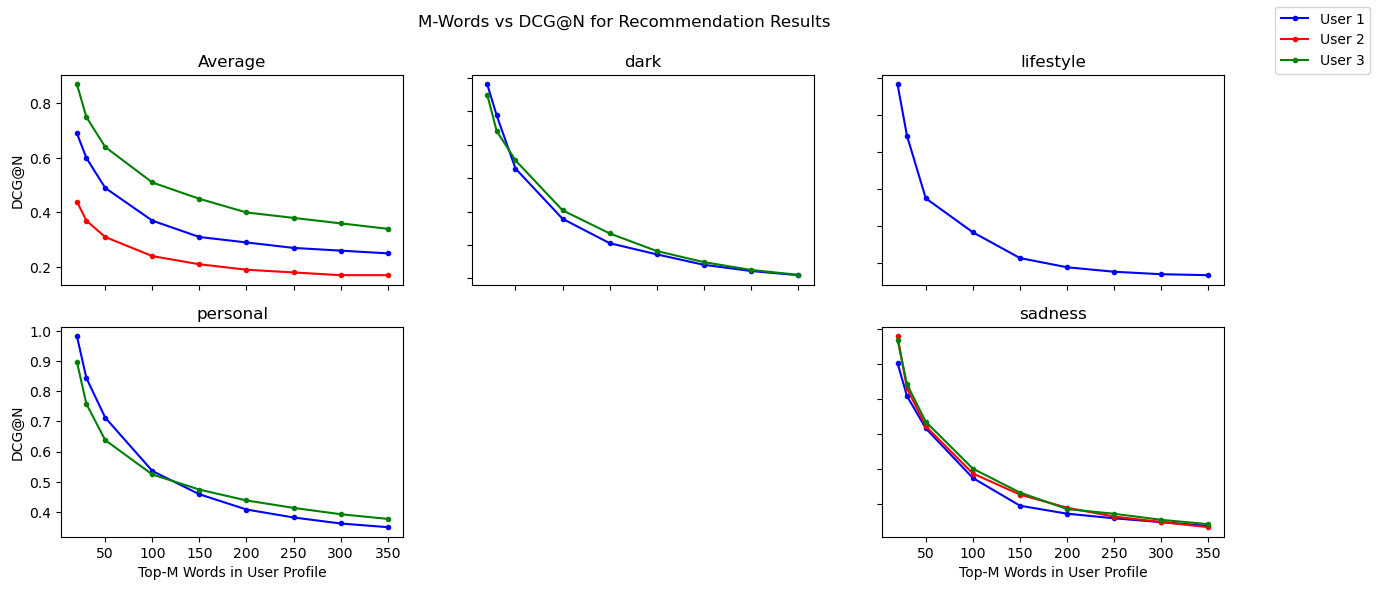

In [38]:
import matplotlib.pyplot as plt

def build_topic_plot(p_x, p_y, usr_1, usr_2, usr_3, topic_to_plot=None):
    # Average Results
    if topic_to_plot is None:
        # Map the User Results to their Average Results
        y_u1 = list(map(lambda x: x[1][0], usr_1))
        y_u2 = list(map(lambda x: x[1][0], usr_2))
        y_u3 = list(map(lambda x: x[1][0], usr_3))

        axs[p_x, p_y].set_title("Average")

        # Plot
        axs[p_x, p_y].plot(m_values, y_u1, label="User 1", marker=".", color="blue")
        axs[p_x, p_y].plot(m_values, y_u2, label="User 2", marker=".", color="red")
        axs[p_x, p_y].plot(m_values, y_u3, label="User 3", marker=".", color="green")

        # Only show the legend for a single plot
        fig.legend(loc = "upper right")

    else: # Plot an individual topic
        y_u1 = []
        y_u2 = []
        y_u3 = []
        zipped_usr_results = zip(usr_1, usr_2, usr_3)

        for y1, y2, y3 in zipped_usr_results:
            y_u1.append(y1[0][topic_to_plot][0])

            if topic_to_plot in y2[0].keys():
                y_u2.append(y2[0][topic_to_plot][0])

            if topic_to_plot in y3[0].keys():
                y_u3.append(y3[0][topic_to_plot][0])

        # Plot all three Users data
        axs[p_x, p_y].plot(m_values, y_u1, label="User 1", marker=".", color="blue")

        if len(y_u2) > 0:
            axs[p_x, p_y].plot(m_values, y_u2, label="User 2", marker=".", color="red")

        if len(y_u3) > 0:
            axs[p_x, p_y].plot(m_values, y_u3, label="User 3", marker=".", color="green")

        axs[p_x, p_y].set_title(topic_to_plot)
    
    axs[p_x, p_y].set_xlabel("Top-M Words in User Profile")
    axs[p_x, p_y].set_ylabel("DCG@N")

fig, axs = plt.subplots(2, 3, figsize=(15,6))
fig.suptitle("M-Words vs DCG@N for Recommendation Results")

# Middle Plot Not Visible
axs[1, 1].set_visible(False)

# Build Plots
build_topic_plot(0, 0, user1_m_results, user2_m_results, user3_m_results, topic_to_plot=None)
build_topic_plot(0, 1, user1_m_results, user2_m_results, user3_m_results, topic_to_plot="dark")
build_topic_plot(0, 2, user1_m_results, user2_m_results, user3_m_results, topic_to_plot="lifestyle")
build_topic_plot(1, 0, user1_m_results, user2_m_results, user3_m_results, topic_to_plot="personal")
build_topic_plot(1, 2, user1_m_results, user2_m_results, user3_m_results, topic_to_plot="sadness")

for ax in fig.get_axes():
    ax.label_outer()



### 5. Model Decision
On the basis of the results, the best algorithm for matching users profiles to songs occurs when the number of words in the profile is constrained. However, it should not be too constrained or results may actually get worse. Thus, on the basis of these results the M-Value should be set to **M = 50**

## Part 3 User Evaluation
**(ASSIGNMENT QUESTION 1)** *Conduct a “user study” of a hypothetical recommender system based on the method chosen in Part 2. The evaluation in Part 2 included a choice of the number N of songs to show the user at any one time. Suppose the user uses your system once per week. Simulate running the recommender system for 3 weeks and training the model at the end of Week 3 using interaction data obtained from the user, and testing the recommendations that would be provided to that user in Week 4.*

The final part of the workbook is the conduction of a "user study". This is where the Multinomial Naive Bayes Classification Algorithm from Part 1 and the Recommender developed in Part 2 are used against a real world user to gain both qualitative and quantitative feedback. This section in broken into the following sections:
1. **Preprocessing:** Where the dataset from Part 1 is again loaded and then preprocessed as per Part 1 into the form required for Part 3.
2. **Building the Weekly Datasets:** Where the code required to build the user training data is developed and explained.
3. **Building the User Profile:** Where the user is provided a sample of data and asked to select which songs they like. This is intended to build a suitable user profile which can be passed to the recommender.
4. **Generating Recommendations:** Where the user profile is passed to the recommender and actual songs are provided to the user. This also includes an examination of which songs the user likes.
5. **Recommender Performance:** This section contains the evaluation of the recommender including qualitative and quantitative performance. General user feedback is also provided in this section.

### 1. Preprocessing
To conduct a user study on the recommender system designed in Part 2, several preprocessing steps must first be conducted, as seen in the code block below. These include:
1. The initial dataset is again reloaded and the preprocessing from Part 1 is again completed to generate the input for each song.
2. The data is then split into 4 sections, with each section simulating one week of potential songs for the user. Weeks 1-3 will act as training data, whilst Week 4 again acts as the recommendation set.
3. The Multinomial Naive Bayes classifier is again trained on the training data set (first three weeks) to allow for song topics to be predicted.

In [39]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Max Features for the classifier (From Part 1)
max_features = 350

# Location of the assignment dataset
dataset_location = "./data/dataset.tsv"

# Load the dataset from TSV file with headers
df = pd.read_csv(dataset_location, sep="\t", header=0)

# Pre-process as per part 1:
df.loc[:, 'release_string'] = df['release_date'].astype(str)
df.loc[:,'input_raw'] = df[['artist_name', 'track_name', 'release_string', 'genre', 'lyrics']].agg(' '.join, axis=1)
df.loc[:, 'input'] = df['input_raw'].apply(preprocess_text)

# Split into weekly data
df_week1 = df.iloc[0:250]
df_week2 = df.iloc[250:500]
df_week3 = df.iloc[500:750]
df_week4 = df.iloc[750:1000]

# Also need the training data for the classifier
df_train = df.iloc[:750]

# Convert the training and test data into TFIDF Vectors
vectorizer = TfidfVectorizer(max_features=max_features)
train_tfidf_full = vectorizer.fit_transform(df_train['input'])
test_tfidf_full = vectorizer.transform(df_test['input'])
mnb = MultinomialNB()

# Train the model on the training data
mnb.fit(train_tfidf_full, df_train['topic'])

MultinomialNB()

### 2. Building the Weekly Datasets
The two methods below are used to build the weekly recommendations. As per the question, each week the user is provided a selection of songs at random from the weekly dataset. In Part 2, it was decided that a good compromise between information overload and the need for useful data was to show the user **5 songs (N=5) for each topic**. This was also supported by Miller's law where $7 \pm 2$ is the magic number for information retention. The two functions are as follows:
- `bucket_week` takes the weekly dataset and transforms them into tfidf vectors (with 350 maximum features as determined in Part 1). The method also uses the classifier to predict the topic, generating the list of songs the user could be presented.
- `weekly_recommender` takes the songs bucketed by topic and using the Numpy random number generator (with a seed for repeatability) provides the 5 songs per topic to the user. The output of this method is the training data (per topic) and the 5 songs provided to the user for each topic in a format that can easily be displayed in an HTML table using *tabulate*.

In [40]:
# Part 2: Recommend a song for each week:
import numpy as np
N = 5

# Bucket all the Weekly songs into the appropriate topic as determined by the classifier
def bucket_week(df_week):
    # Build a dictionary to hold songs from all topics
    weekly_songs = {}
    topics = df_week['topic'].unique().tolist()
    for key in topics:
        weekly_songs[key] = []

    # Vectorise the weekly songs:
    week_tfidf = vectorizer.transform(df_week['input'])

    # Then bucket into topics
    for index, tfidf_value in enumerate(week_tfidf):
        # Also get the predicted topic:       
        predicted_topic = mnb.predict(tfidf_value)[0]
        weekly_songs[predicted_topic].append(df_week.iloc[index])
    return weekly_songs

# Provide N songs PER topic to the user for the weekly data
def weekly_recommender(df_week, num_songs, week, seed, print_results=True):    
    # Get songs to recommend
    rng = np.random.default_rng(seed)
    
    # Output table data and dictionary
    recommendations = [["#", "Index", "Dataset Idx", "Artist Name", "Track Name", "Genre", "Topic"]]
    weekly_dict = {}

    # For each topic
    songs_by_topic = bucket_week(df_week)
    total_songs_shown = 0
    for key, song_list_for_topic in songs_by_topic.items():
        songs_to_show = num_songs if len(song_list_for_topic) >= num_songs else len(song_list_for_topic)
        if print_results:
            print("Choosing " + str(songs_to_show) + " " + key + " songs from " + str(len(song_list_for_topic)))

        # No songs to choose from
        if len(song_list_for_topic) == 0:
            weekly_dict[key] = pd.DataFrame([])
            continue    

        song_df = pd.DataFrame(song_list_for_topic)
        weekly_dict[key] = song_df

        # Print out N random songs to the user:
        indexes = rng.choice(len(song_list_for_topic), size=songs_to_show, replace=False)
        for index in range(0, songs_to_show):
            total_songs_shown += 1
            original_song = song_df.iloc[indexes[index]]
            dataset_idx = (week -1) * 250 + indexes[index]

            recommendations.append([total_songs_shown, indexes[index], dataset_idx, original_song["artist_name"], original_song["track_name"], original_song["genre"], key])
    return recommendations, weekly_dict

#### Building the Training Data
The final two methods used in the user study revolve around turning the user recommendations into training data.
- `build_blank_user_dict` simply creates a blank dictionary for each of the 5 topics, ready to hold the training data.
- `build_training_data` takes the results of the weekly recommendations (in a data structure shown later) and, for each index in the data structure, the algorithm will find the matching song from the weekly song list and add it to the provided dictionary. This will produce an updated training dictionary that has only the songs the user 'likes', hence results in the generation of the user profile.

In [41]:
# Build initial dictionary
def build_blank_user_dict():
    topics = df['topic'].unique().tolist()
    user_dict = {}
    for key in topics:
        user_dict[key] = []
    return user_dict

# Get the songs from the weekly dictionary and add them to training data:
def build_training_data(liked_songs_dict, weekly_dict, index_dict):
    new_liked_songs_dict = liked_songs_dict.copy()
    for key, liked_indexes in index_dict.items():
        songs_to_add = []
        weekly_songs_df = weekly_dict[key]

        if len(liked_indexes) == 0: # No songs to add
            continue

        # Get the individual song and add to training set
        for index in liked_indexes:
            original_song = weekly_songs_df.iloc[index]
            songs_to_add.append(original_song)

        # Now append to dataframe:
        new_liked_songs_dict[key] = liked_songs_dict[key] + songs_to_add

    return new_liked_songs_dict

### 3. Building the User Profile
**(ASSIGNMENT QUESTION 1)** *Choose one friendly “subject” and ask them to view (successively over a period of 4 simulated weeks) N songs chosen at random for each “week”, for Weeks 1, 2 and 3, and then (after training the model) the recommended songs from Week 4. The subject is someone without knowledge of recommendation algorithms who will give useful and unbiased feedback. To be more precise, the user is shown 3 randomly chosen batches of N songs, one batch from Week 1 (N songs from 1 to 250), one batch from Week 2 (N songs from 251 to 500), and one batch from Week 3 (N songs from 501 to 750), and says which of these they “like”. This gives training data from which you can then train a recommendation model using the method in Part 2.*

The codeblocks below show the conduct of the user study across, each of the three weeks. First the `weekly_recommender` generates the song list pseudo-randomly. A seed is provided to generate the list of 20-25 songs (depending on if there were sufficient songs from the emotional category, which as seen earlier is a know weakness of the classifier).

#### Notes about the User:
The user in question is a late-twenties female who is not a student at UNSW and has no knowledge of recommendation systems. The user however is very familiar with using such systems including Spotify and YouTube music. As the user in question has quite specific music tastes (various subsets of the alternative genre), it was not enough to simply provide the songs at random. The seed was required to be changed a few times until there were sufficient songs in the list for the user to provide some level of relevant data.

#### Conducting the User Study: Weeks 1-3
The list of songs presented to the user for Week 1 is shown below:

In [42]:
week1_songs, week1_dict = weekly_recommender(df_week1, N, week=1, seed=62)
table = tabulate.tabulate(week1_songs, tablefmt="html")
table

Choosing 5 dark songs from 101
Choosing 5 lifestyle songs from 19
Choosing 5 sadness songs from 65
Choosing 1 emotion songs from 1
Choosing 5 personal songs from 64


#,Index,Dataset Idx,Artist Name,Track Name,Genre,Topic
1,59,59,black pistol fire,pick your poison,blues,dark
2,56,56,michael w. smith,surrounded (fight my battles),rock,dark
3,81,81,spoon,hot thoughts,rock,dark
4,43,43,james arthur,train wreck,pop,dark
5,74,74,imagine dragons,natural,rock,dark
6,10,10,james arthur,can i be him,pop,lifestyle
7,15,15,michael franti & spearhead,i got love for ya,reggae,lifestyle
8,8,8,pacific dub,what you like,reggae,lifestyle
9,3,3,brett young,here tonight,country,lifestyle
10,9,9,mike ryan,the rewrite,country,lifestyle


#### Week 1 Results:
From the 21 songs provided to the user, 5 songs were identified as something they would like. The results for each category are:
- **Dark** the only artist from this category the user even knew of was Image Dragons so *"natural"* was an easy choice. James Arthur was not an artist familiar to the user but was a reasonable choice.
- **Lifestyle** the user had again not really heard any of these artists. They played the second James Arthur song *"Can I be Him"* and thought it was okay.
- **Sadness** the user was already a fan of *Yungblud*, so found their song (*"Hope for the Underrated Youth"*) easy to like. They had not heard any of the other artists.
- **Emotion** only one song was classified under this topic and the user did not like it.
- **Personal** the user had previously heard of *The Struts*, but not this song in particular, though ended up liking it. No other song was suitable.

In general, the user struggled to find suitable songs. This was mostly expected as the recommender system does not consider genre as a configurable input as per the specification. If rock (or better yet a deeper ontology to allow subgenres of rock) to be an input would have led to better songs.

The codeblock below, denotes the indices of the liked songs as well as displayed the Week 2 songs. Note whilst the table above may not show the same songs (due to issues with Numpy seeds), it is representative of what the user experienced.

In [43]:
# Build user_profile:
user_liked_songs_df = build_blank_user_dict()


# Enter Week 1 Liked songs here:
week1_liked_songs = {
    "dark": [96, 43],
    "lifestyle": [10],
    "sadness": [29],
    "emotion": [],
    "personal": [63],
}

week1_train_dict = build_training_data(user_liked_songs_df, week1_dict, week1_liked_songs)

week2_songs, week2_dict = weekly_recommender(df_week2, N, week=2, seed=78)
table = tabulate.tabulate(week2_songs, tablefmt="html")
table


Choosing 5 lifestyle songs from 18
Choosing 5 personal songs from 63
Choosing 5 dark songs from 105
Choosing 5 sadness songs from 64
Choosing 0 emotion songs from 0


#,Index,Dataset Idx,Artist Name,Track Name,Genre,Topic
1,6,256,the green,mama roots (feat. j boog),reggae,lifestyle
2,15,265,jo mersa marley,point of view,reggae,lifestyle
3,1,251,nahko and medicine for the people,directions,reggae,lifestyle
4,10,260,vince staples,big fish,hip hop,lifestyle
5,3,253,pepper,bones,reggae,lifestyle
6,23,273,taylor swift,i did something bad,pop,personal
7,34,284,stone sour,song #3,rock,personal
8,61,311,foo fighters,run,rock,personal
9,25,275,the record company,i'm changing,blues,personal
10,21,271,jamiroquai,automaton,jazz,personal


#### Week 2 Results:
From the 20 songs provided to the user, 4 songs were identified as something they would like. The results for each category are:
- **Dark** the user liked one song from this topic, again being *Yungblud*.
- **Lifestyle** the user did not find any suitable songs in this category. It was noted that all the genres in this topic were *reggae* and *hip-hop*, not ones the user likes.
- **Sadness** despite the users strong dislike of most country songs, the user did find *Jelly Roll* acceptable.
- **Emotion** no emotion songs were available for recommendation.
- **Personal** two songs were chosen here, both unsurprisingly Rock. As the user has seen both *Foo Fighters* and *Stone Sour* live, they were easy picks.

In general, the user again was drawn to the Rock category, though the random recommender did pick a few surprises. Again, the codeblock below, denotes the indices of the liked songs as well as displayed the Week 3 songs.

In [44]:
# Enter Week 2 Liked songs here:
week2_liked_songs = {
    "dark": [86],
    "lifestyle": [],
    "sadness": [20],
    "emotion": [],
    "personal": [61, 34],
}

week2_train_dict = build_training_data(week1_train_dict, week2_dict, week2_liked_songs)

week3_songs, week3_dict = weekly_recommender(df_week3, N, week=3, seed=97) #12, 2, 16 23 27 42 49 97
table = tabulate.tabulate(week3_songs, tablefmt="html")
table

Choosing 5 lifestyle songs from 24
Choosing 5 dark songs from 80
Choosing 5 sadness songs from 66
Choosing 5 personal songs from 80
Choosing 0 emotion songs from 0


#,Index,Dataset Idx,Artist Name,Track Name,Genre,Topic
1,2,502,the marcus king band,radio soldier,blues,lifestyle
2,14,514,the record company,coming home,blues,lifestyle
3,9,509,eric church,hippie radio,country,lifestyle
4,13,513,phish,waiting all night,blues,lifestyle
5,21,521,dorothy,philadelphia,blues,lifestyle
6,45,545,kenny chesney,song for the saints,country,dark
7,58,558,fall out boy,church,rock,dark
8,15,515,avril lavigne,head above water,pop,dark
9,13,513,all them witches,rob's dream,blues,dark
10,2,502,muse,thought contagion,rock,dark


#### Week 3 Results:
From the 20 songs provided to the user, 4 songs were identified as something they would like. The results for each category are:
- **Dark** the user liked three songs from this topic, with the user being a fan of *Fall Out Boy* and *Avril Lavigne* as well as occasionally a fan of *Muse*.
- **Lifestyle** the user did not find any suitable songs in this category. It was again noted that all the genres in this topic were blues or country, not ones the user likes.
- **Sadness** the user liked 2 songs from this category, as the user is a fan of *Panic! at the Disco*, this was an easy pick. The user occasionally can handle *Korn* (as it can be too heavy for the users tastes) but this song was good enough.
- **Emotion** no emotion songs were available for recommendation.
- **Personal** the user was unable to find a song in this category.

In general, the user again was drawn to the Rock category, with some of the pop songs on the "pop-ier" side of Pop-Punk. Again, the codeblock below, denotes the indices of the liked songs as well as displayed the Week 3 songs.

In [45]:
# Enter Week 2 Liked songs here:
week3_liked_songs = {
    "dark": [7, 61],
    "lifestyle": [1],
    "sadness": [34, 50, 47],
    "emotion": [],
    "personal": [],
}

week3_train_dict = build_training_data(week2_train_dict, week3_dict, week3_liked_songs)

### Final Recommendations
**(ASSIGNMENT QUESTION 1)** The user is then shown a batch of recommended songs from Week 4 (N songs from 751 to 1000) in rank order, and metrics are calculated based on which of these songs the user likes. Show all these metrics in a suitable form (plots or tables).*

The next code block follows the work from Part 2, where the now complete training data and the Week 4 songs are passed to the previously built recommender algorithm. The recommended songs were then passed to the user and the following comments made:
- **Dark** despite *Dark* being the topic the user had the most liked songs, what was recommended delivered mixed results.
    - *Adam Jensen - They Mystic:* The user did not know this song, but actually liked it, they even commented that they may add this to their Spotify playlist.
    - *Grandson - Stigmate:* The user commented that the artist sounded familiar, but did not like this song.
    - *Rick Braun - Around the Corner:* The user did not know this song and found the trumpets interesting. They did not like this song enough to say it was relevant. They also noted this song did not fit the Dark category (despite correct classification).
    - *Sticky Fingers - Outcast at Last:* The user mentioned the artist sounded familiar but did not like the song
    - *Pretty Much - Would you mind:* The user did not like this song at all.
- **Lifestyle** as with dark, the user identified several songs in the training set but the recommender delivered mixed results:
    - *Wolfmother - Baroness:* The user is a fan of this artist and did not know this song.
    - *Fumez The Engineer* - Pull Up Hop Out Band - we were unable to find this song to play to the user but as it was Hip-Hop, the user was unlikely to like this song.
    - *Digitalluc - rethymn:* The user did not like this song.
    - *Trina - 100%:* The user did not like this song.
    - *Brothers Osborne - 21 summer:* The user did not like this song.
- **Sadness** the user liked a few songs from this, so expected to get some reasonable recommendations
    - *Naomi Scott - Speechless:* Initially the user did not know this song. On playing, they realised it was from Aladdin and also liked the song.
    - *311 - Hey Yo:* The user is aware of this band as they fit the correct genre for their tastes but had not heard them before. This was not a song they liked.
    - *Brett Young - Close Enough:* The user did not know this song and as it was country, did not like it.
    - *Zac Efron - Rewrite the Stars:* The user expected to not like this song based on the artist, but actually didn't mind it, as they liked the movie the song was from (The Greatest Showman).
    - *Two Door Cinema Club - once:* The user did not like this song.
    One note to make was that if no limit to M words in the profile was used, *Killswitch Engage* would have been recommended, a song that the user commented they would have liked.
- **Emotion** no emotion songs were available for recommendation.
- **Personal** the user struggled to find songs in this category so did not have high hopes. That assumption was true as they did not like any songs in this category.

In general the user was surprised to find a few decent recommendations. This was despite the limitations placed on the input data, as it was hard to find enough training samples to make a useful profile. The metrics are held until the next section, as metrics require some form of truth data.

In [46]:
# Vectorise the weekly data
week4_tfidf = vectorizer.transform(df_test['input'])

# Bucket into topics
week4_dict, week_4_tfidf_dict, train_classifications = bucket_songs(df_week4, week4_tfidf, print_results=False)

# User Profile
user_study_profile = week3_train_dict

recommended_songs = recommend_songs(user_study_profile, week4_dict, week_4_tfidf_dict, N, m_words=50, print_results=True)

For Topic dark recommended songs are:
1: adam jensen - the mystic (0.2624)
2: grandson - stigmata (0.205)
3: rick braun - around the corner (0.1956)
4: sticky fingers - outcast at last (0.1931)
5: prettymuch - would you mind (0.1899)


For Topic lifestyle recommended songs are:
1: wolfmother - baroness (0.382)
2: fumez the engineer - pull up hop out bang (0.318)
3: digitalluc - rethymno (0.308)
4: trina - 100% (0.2692)
5: brothers osborne - 21 summer (0.257)


For Topic sadness recommended songs are:
1: naomi scott - speechless (full) (0.2357)
2: 311 - hey yo (0.2354)
3: brett young - close enough (0.2348)
4: zac efron - rewrite the stars (0.2249)
5: two door cinema club - once (0.214)


For Topic emotion recommended songs are:
No liked songs in profile for topic emotion
For Topic personal recommended songs are:
1: iya terra - follow your heart (feat. zion thompson from the green) (0.343)
2: palace - live well (0.3286)
3: anita baker - no one in the world (0.3275)
4: ty segall - alta (

### 4. Recommender Performance:
#### Quantitative Analysis
 The table below shows some of the original metrics from Part 2, recalculated by hand using the same definitions as earlier. This time however the relevance is determined by whether the user thought it was relevant, not what the 'truth' data thought it should be. The one additional metric that was not shown in Part 2 is hit rate. Hit rate is simply whether any relevant songs showed up at all in the list. This was excluded from Part 2 as it was essentially 1 in all cases (except emotion), though has more interesting results here. From this table, you can see that the Perfect Training data did in fact perform slightly better for precision but worse in reciprical rank (as well as worse across everything in lifestyle). This correlates with the users qualitative thoughts described at the end of this section.


In [47]:
print(" "*20 + "Metrics Calculated against what songs the user actually liked")
data = [["Topic", "dark", "lifestyle", "sadness", "emotion", "personal", "Average"],
        ["Real Recommender Precision@N", 0.2, 0.2, 0.4, 0, 0, 0.16 ],
        ["Real Recommender Reciprical Rank@N", 1, 1, 1, 0, 0, 0.6],
        ["Real Recommender Average Precision@N", 1, 1, 0.75, 0, 0, 0.55],
        ["Real Recommender Hit Rate@N", 1, 1, 1, 0, 0, 0.6],
        ["Perfect Training Data Precision@N", 0.4, 0, 0.6, 0, 0, 0.2],
        ["Perfect Training Data Reciprical Rank@N", 0.5, 0, 0.5, 0, 0, 0.2],
        ["Perfect Training Data Average Precision@N", 0.5, 0, 0.638, 0, 0,  0.2276],
        ["Real Recommender Hit Rate@N", 1, 0, 1, 0, 0, 0.2]]
table = tabulate.tabulate(data, tablefmt="html")
table

                    Metrics Calculated against what songs the user actually liked


Topic,dark,lifestyle,sadness,emotion,personal,Average
Real Recommender Precision@N,0.2,0.2,0.4,0,0,0.16
Real Recommender Reciprical Rank@N,1,1,1,0,0,0.6
Real Recommender Average Precision@N,1,1,0.75,0,0,0.55
Real Recommender Hit Rate@N,1,1,1,0,0,0.6
Perfect Training Data Precision@N,0.4,0,0.6,0,0,0.2
Perfect Training Data Reciprical Rank@N,0.5,0,0.5,0,0,0.2
Perfect Training Data Average Precision@N,0.5,0,0.638,0,0,0.2276
Real Recommender Hit Rate@N,1,0,1,0,0,0.2


#### Attempt at Generating Truth Data
As the user noted that they struggled to even find songs in the first 3-week training set. It was postulated that the recommender was poor because the training data was poor. In an attempt to test that theory, the user profile was again built, but this time instead of random songs provided to the user, ALL the songs the user liked in the first three weeks were provided. The recommended songs for this data can act as another way of determining the best case truth data.

The `build_all_week_df` method builds the predicted topic buckets (rather than the true ones) for the first three weeks and provides a way of generating a CSV file for the user to pick the songs (by index) they liked.

Once complete, the user identified 31 songs TOTAL that they would have liked if they could build their own history. That is shown in the table below. Of note the topic breakup was 15 *dark*, 2 *lifestyle*, 10 *sadness* and 4 *personal*

In [48]:
# Second Attempt: Perfect history - how does it compare:
def build_all_week_df(weekly_df, week_dict):
    concatenated_df = weekly_df.copy()
    for key, weekly_songs in week_dict.items():
        index_series = [index for index in range(0, len(weekly_songs))] # Index of song in dictionary list
        topic_series = [key for _ in range(0, len(weekly_songs))] # Everything has the same topic

        # Append new columns to the dataframe from this data
        extra_df = weekly_songs.copy()
        extra_df['Index'] = index_series
        extra_df['pred_topic'] = topic_series

        # Concatenate
        concatenated_df = pd.concat([concatenated_df, extra_df], ignore_index=True)
    return concatenated_df

output_df = pd.DataFrame([])

week1_songs_perfect, week1_dict_perfect = weekly_recommender(df_week1, N, week=1, seed=56, print_results=False)
output_df = build_all_week_df(output_df, week1_dict_perfect)

week2_songs_perfect, week2_dict_perfect = weekly_recommender(df_week2, N, week=1, seed=56, print_results=False)
output_df = build_all_week_df(output_df, week2_dict_perfect)

week3_songs_perfect, week3_dict_perfect = weekly_recommender(df_week3, N, week=1, seed=56, print_results=False)
output_df = build_all_week_df(output_df, week3_dict_perfect)

# Print out the full dataset to csv (to get the indexes)
#output_df.to_csv("perfect_test.csv", index=False)

# Build user_profile:
user_liked_songs_df = build_blank_user_dict()

# Enter Week 1 Liked songs here:
week1_liked_songs = {
     "dark": [17, 66, 74],
    "lifestyle": [0],
    "sadness": [9, 29, 41],
    "emotion": [],
    "personal": [],
}
week1_train_dict_perfect = build_training_data(user_liked_songs_df, week1_dict_perfect, week1_liked_songs)

# Enter Week 2 Liked songs here:
week2_liked_songs = {
    "dark": [14, 16, 22, 33, 39, 86],
    "lifestyle": [],
    "sadness": [5],
    "emotion": [],
    "personal": [34],
}
week2_train_dict_perfect = build_training_data(week1_train_dict_perfect, week2_dict_perfect, week2_liked_songs)

# Enter Week 3 Liked songs here:
week3_liked_songs = {
    "dark": [15, 27, 28, 58, 61, 79],
    "lifestyle": [22],
    "sadness": [12, 18, 34, 43, 60, 65],
    "emotion": [],
    "personal": [17,34,72],
}
week3_train_dict_perfect = build_training_data(week2_train_dict_perfect, week3_dict_perfect, week3_liked_songs)

# Build a table of all liked songs:
data = [["Song", "Artist Name", "Track Name", "Genre", "Topic"]]
count = 0
for topic, song_list in week3_train_dict_perfect.items():
    for idx, song in enumerate(song_list):
        count += 1        
        # Find in original list:
        data.append([count, song["artist_name"], song["track_name"], song["genre"], topic])

table = tabulate.tabulate(data, tablefmt="html")
table

Song,Artist Name,Track Name,Genre,Topic
1,korn,a different world (feat. corey taylor),rock,dark
2,skillet,anchor,rock,dark
3,imagine dragons,natural,rock,dark
4,yungblud,kill somebody,rock,dark
5,yungblud,loner,rock,dark
6,metallica,now that we're dead,rock,dark
7,will smith,men in black,hip hop,dark
8,twenty one pilots,jumpsuit,pop,dark
9,yungblud,doctor doctor,rock,dark
10,avril lavigne,head above water,pop,dark


#### Results from 'Perfect' Training Data
Repeating the results with the new training data, producing the following results:
- **Dark** 2 of the original songs stayed in this list; *Adam Jensen* was liked, whilst *Granson* was not. Of the other three:
    - *deca - donner bell:* The user did not like this song.
    - *nothing but thieves - amsterdam:* The user thought they did not know this artist but liked the song. It turned out they had actually liked another of the artists songs on Spotify. This was a good recommendation.
    - *eric church - the snake:* The user did not like this song.
- **Lifestyle** compared to the original user study, every song was different, implying zero relevance to the previous recommendations. Of the new 5 songs, the user liked none of them (which is actually one worse than the original test set). This is not surprising as only two songs were liked in the training set.
- **Sadness** again 2 of the original songs were in both sets, the user actually liked both of them. Of the 3 new songs:
    - *the movement - home:* The user did not like this song.
    - *the dear hunter - the revival* - The user did not know this song but on playing 'kinda' liked it. It also reminded them of *Panic! at the Disco* which had one liked song in *Sadness*.
    - *the lumineers - walls:* The user did not like this song.
- **Emotion** no emotion songs were available for recommendation.
- **Personal** as more songs were liked in this category when using the perfect training set, it was assumed the results may be better. Only the top recommendation was in both sets (that they did not like), of the other four, the user did not like any.


In [49]:
# Vectorise the weekly data
week4_tfidf = vectorizer.transform(df_test['input'])

# Bucket into topics
week4_dict_perfect, week_4_tfidf_dict_perfect, train_classifications = bucket_songs(df_week4, week4_tfidf, print_results=False)

# User Profile
user_study_profile = week3_train_dict_perfect

recommended_songs_perfect = recommend_songs(user_study_profile, week4_dict_perfect, week_4_tfidf_dict_perfect, N, m_words=50, print_results=True)

For Topic dark recommended songs are:
1: grandson - stigmata (0.1908)
2: alec benjamin - boy in the bubble (0.1761)
3: deca - donner bell (0.1616)
4: nothing but thieves - amsterdam (0.154)
5: eric church - the snake (0.1524)


For Topic lifestyle recommended songs are:
1: adam hambrick - all you, all night, all summer (0.3543)
2: girl in red - summer depression (0.3532)
3: brothers osborne - 21 summer (0.3463)
4: diana krall - but not for me (0.3003)
5: midland - every song’s a drinkin’ song (0.2101)


For Topic sadness recommended songs are:
1: the movement - home (0.2188)
2: the dear hunter - the revival (0.2167)
3: naomi scott - speechless (full) (0.2141)
4: zac efron - rewrite the stars (0.2124)
5: the lumineers - walls (0.2095)


For Topic emotion recommended songs are:
No liked songs in profile for topic emotion
For Topic personal recommended songs are:
1: iya terra - follow your heart (feat. zion thompson from the green) (0.279)
2: cold war kids - complainer (0.2755)
3: the ban

#### Comparison between Perfect Training Data and Recommendations:
**(ASSIGNMENT QUESTION 1)** *Ask the subject to talk aloud but make sure you find out which songs they are interested in. Calculate and show the various metrics for the Week 4 recommended songs that you would show using the/ model developed in Part 2. Explain any differences between metrics calculated in Part 2 and the metrics obtained from the real user. Finally, mention any general user feedback concerning the quality of the recommendations*

When comparing the recommender with the real data and the perfect training data, the impact on relevance becomes clear. The topics with the most input data (*dark* and *sadness*), performed the best and when even more training data is added, perform even better. The topics with low training data performed worse. The impact of categories also did not help.

One very important factor was that of the test set itself. When provided to the user, they noted that only they would have expected to have liked the following 6 songs - of which only one was actually recommended. The provides context that no matter how good or bad the recommender actually is, it will always be limited by the quality of the dataset.
 - *blink-182 - bored to death*
 - *queens of the stone age - fortress*
 - *killswitch engage - I am broken too*
 - *killswitch engage - us against the world*
 - *wolfmother - baroness*
 - *alice cooper - paranormal*


##### Metric Comparison Using Metrics from Part 2
This section of the assignment calculates the metrics from Part 2 for the recommended songs compared to the 'truth' recommended songs. From these metrics the following results can be seen.
- **Dark** has the lowest DCG@N (excluding emotion with 0 recommendations), as well as 0% accuracy, 0.5 reciprical rank and 20% precision.
- **Lifestyle** has the second highest DCG@N, but 0% precision, the lowest reciprical rank (0.2) and 20% precision.
- **Sadness** has the second lowest DCG@N, 20% accuracy and the highest Precision (40%) and reciprical rank (1).
- **Emotion** no emotion songs were available for recommendation.
- **Personal** has the highest DCG@N, a 20% accuracy and precision, highest Reciprical Rank (1).
- **Mean** the mean results had a reasonable DCG@N, very low accuracy (8%), low precision (20%) and a mean reciprical rank of slightly better than 0.5.

When looking at these results in isolation, the results seem okay. Though when comparing with the users comments they start to get interesting. Firstly when looking at the users definition of relevance rather than the truth data, the two best performing topics from the users point of view (*dark* and *sadness*) had the two lowest DCG@N scores, whilst the best performers (*lifestyle* and *personal*) had the worst results (again excluding *emotion*). Secondly most of these metrics calculate relevance based on comparison to the 'ideal' ranking (in this case the recommender built off perfect training data). As stated above, this is a poor assumption as the user was only able to find 6 songs across ALL topics that were actually relevant when provided the test data, making the question set up to fail from the start. As already discussed above, the true purpose of the recommender system was to generate NEW songs that the user not only liked but had never heard of before. Hence, determining a relevance of the truth data is not as easily defined.

When compared to the earlier table of the users real metrics, you can also see that the users results has slightly worse precision and average precision (identical for dark and lifestyle but worse for sadness), but performed better in Reciprical Rank (and Mean Reciprical Rank).

In [50]:
# Use the metrics from Part 2 to compare the recommended songs vs the 'truth' recommended songs
user_study_results, user_study_average_results = compare_results(recommended_songs, week4_dict, recommended_songs_perfect, week4_dict_perfect, N)

# Print the results
data = [["Topic", "DCG@N", "NDCG@N", "Accuracy@N", "Reciprical Rank", "Precision@N", "Average Precision@N"]]

for topic, topic_result in user_study_results.items():
    data.append([topic] + topic_result)
data.append(["Mean"] + user_study_average_results)

print(" "*25 + "Results using Perfect Recommender as Truth Data")
table = tabulate.tabulate(data, tablefmt="html")
table

                         Results using Perfect Recommender as Truth Data


Topic,DCG@N,NDCG@N,Accuracy@N,Reciprical Rank,Precision@N,Average Precision@N
dark,0.6462,1.0,0.0,0.5,0.2,1.0
lifestyle,0.952,1.0,0.0,0.2,0.2,1.0
sadness,0.6812,1.0,0.2,1.0,0.4,1.0
emotion,0,0,0,0,0,0
personal,0.9778,1.0,0.2,1.0,0.2,1.0
Mean,0.65,0.8,0.08,0.54,0.2,0.8


#### General User Comments
In general, the user had several items of qualitative feedback that affected their opinion of the process. Firstly the user specifically called out the input data, by which they were quoted as saying "the reason they like songs is not necessarily the lyrics" so building a content-based recommender that uses lyrics as a primary feature was not expected to work well. Secondly, the user called out the size of the dataset with the total number of songs the user liked when building the training set only being 31 (or 4% of total data). This made building the user profile difficult as sufficient information needed to be provided for a reasonable recommendation. Next the user stated the impact of a flawed ontology for genre, with the lack of subgenres meaning that very dissimilar songs were seemingly related and incorrect labelling of genres also limiting the chance of success. This was called out in Part 1 during initial data investigation. Finally, the biggest problem the user had concerned the topics themselves. Whilst the user was able to develop a general understanding of what *sad* songs meant, the other categories seemed quite vague. The user seemed okay describing their music tastes as *dark* or *emotion* as they relate to their preferred subgenres of *emo*, *alternative*, *pop-punk* and *metalcore*, they were unsure if the *emotion* category had the same meaning. Additionally, the user had no idea what *personal* or *lifestyle* was supposed to mean, indicating that they saw *sadness* as a subset of *personal*. They also said they have no idea how to categorise some popular bands in the dataset including *The Killers* (categorised as *dark*, when most of their songs are more *personal*) and *Panic! at the Disco - The Greatest Show* being classified as *sadness* when it is "literally about how great they are".

#### Final Conclusion
Overall, the recommender system had to be considered a success, purely on the basis that when sufficient data samples were given by the user allowing a reasonable profile to be developed, the system successfully recommended one of the six songs the user knew they would like plus three songs the user ended up liking, that they did not expect. As a recommender should be providing users with new songs, not songs they are already familiar with, this can be seen as a good .

## References
A. NLTK Project (2023). *nltk.tokenize.word_tokenize*  Available: https://www.nltk.org/api/nltk.tokenize.word_tokenize.html. Date Accessed: 24/06/2025

B. NLTK Project (2024). *Sample Usage for Stem* Available: https://www.nltk.org/howto/stem.html. Date Accessed: 24/06/2025

C. Porter, M (2006). *The Porter Stemming Algorithm* Available: https://tartarus.org/martin/PorterStemmer/. Date Accessed: 24/06/2025

D. Regex 101 (2025). *Regular Expressions 101* Available: https://regex101.com/. Date Accessed: 24/06/2025

E. SciKit-Learn (2025). *Cross-validation: evaluating estimator performance* Available: https://scikit-learn.org/stable/modules/cross_validation.html. Date Accessed: 24/06/2025/

F. Pierian Training (2023). *Understanding Cross Validation in Scikit-Learn with cross_validate*. Available: https://pieriantraining.com/understanding-cross-validation-in-scikit-learn-with-cross_validate/. Date Accessed: 24/06/2025.

G. SciKit-Learn (2025). *Naive Bayes* Available: https://scikit-learn.org/stable/modules/naive_bayes.html. Date Accessed: 24/06/2025.

H. Shafl, A (2024). *Random Forest Classification with Scikit-Learn* Available: https://www.datacamp.com/tutorial/random-forests-classifier-python. Date Accessed: 24/06/2025.

I. IBM (2025). *What is random forest?* Available: https://www.ibm.com/think/topics/random-forest. Date Accessed: 24/06/2025.

J. SciKit-Learn (2025). *Feature Extraction* Available: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction. Date Accessed: 24/06/2025.

K. Evidently AI (2025). *10 metrics to evaluate recommender and ranking systems* Available: https://www.evidentlyai.com/ranking-metrics/evaluating-recommender-systems. Date Accessed: 24/06/2025.

L. Deutschman, Z (2023). *Recommender Systems: Machine Learning Metrics and Business Metrics* Available: https://neptune.ai/blog/recommender-systems-metrics. Date Accessed: 24/06/2025.

M. Laws of UX (2025). *Miller's Law*. Available: https://lawsofux.com/millers-law. Date Accessed: 24/06/2025